# Wind Turbine Power output in a changing environment

### How a changing environmental factors has affected wind turbine power generation.
### Has changing environmental factors led to more maintainance tasks being performed on the turbines

### Load Initial Packages

In [2]:
"""
Created on Sat Oct 16 15:08:50 2021

@author: lawrencer
"""
#Set up of the packages
import altair as alt
import pandas as pd
import numpy as np
import os
import io
import ftplib
import altair as alt
import math
import sklearn as sk
from scipy import spatial
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns

root_local = "C:/Users/lawrencer/OneDrive - City, University of London/Turbine/"
load_data = True

In [3]:
ftp = ftplib.FTP('ftp.ceda.ac.uk')
ftp.login('username' , 'password')

download_years = ["%.0f.csv" % x for x in np.arange(2015,2021)]

### Government Windfarm

#### Get wind farm data

In [3]:
if load_data:
    farm_raw = pd.read_csv(root_local + "renewable-energy-planning-database-q2-june-2021.csv")

    farm = farm_raw[farm_raw["Technology Type"].isin(["Wind Onshore", "Wind Offshore"])]
    farm = farm[farm["Development Status"] == "Operational"]
    farm = farm.rename(columns={"X-coordinate": "X", "Y-coordinate": "Y"})

    cols = ["Ref ID","Operator (or Applicant)","Site Name","Technology Type","Installed Capacity (MWelec)",
    "Turbine Capacity (MW)","No. of Turbines","Height of Turbines (m)","Address","County","Region","Country",
    "X","Y"]

    farm = farm[cols]

    cap = farm["Installed Capacity (MWelec)"]
    farm["Installed Capacity (MWelec) Norm"] = (cap-min(cap))/(max(cap)-min(cap))

    farm_coord = pd.read_csv(root_local + "farm_coord.csv")
    farm_coord = farm_coord.drop(['X', 'Y'], axis=1)
    farm = pd.merge(farm, farm_coord, on = 'Ref ID')
    farm["X"] = round(farm["X"],0)
    farm["Y"] = round(farm["Y"],0)

    #gets rid of nas for capacity. This is based on the fact that  there are numbers for installed 
    #capacity and number of turbines present
    farm["Turbine Capacity (MW)"] = farm["Turbine Capacity (MW)"].fillna(farm["Installed Capacity (MWelec)"] 
                                                                         / farm["No. of Turbines"])
farm.head(2)

Ref ID Operator (or Applicant)  \
0    2479                 Statoil   
1    2485         Talisman Energy   

                                           Site Name Technology Type  \
0  Hywind Scotland Pilot Park (Hywind 2) Demonstr...   Wind Offshore   
1                              Beatrice Demonstrator   Wind Offshore   

   Installed Capacity (MWelec)  Turbine Capacity (MW)  No. of Turbines  \
0                         30.0                    6.0              5.0   
1                         10.0                    5.0              2.0   

   Height of Turbines (m)                           Address    County  \
0                     NaN  Buchan Deeps, 20km off Peterhead  Offshore   
1                     NaN        Beatrice Offshore Platform  Offshore   

     Region   Country         X         Y  Installed Capacity (MWelec) Norm  \
0  Offshore  Scotland  433500.0  846500.0                          0.024837   
1  Offshore  Scotland  347955.0  929690.0                          0.008168   

   SV0000000000        lat      long  
0  NK3350046500  57.507463 -1.442575  
1  ND4795529690  58.252812 -2.888431

In [189]:
farm.shape

(786, 18)

#### Add closest stations

##### Wind

In [4]:
wind_meta = pd.read_csv(root_local + "midas-open_uk-mean-wind-obs_dv-202007_station-metadata.csv", skiprows=46)
wind_coord = pd.read_csv(root_local + "wind_coord.csv")
wind_coord = wind_coord[["X","Y","station_file_name"]]
wind_meta = pd.merge(wind_meta, wind_coord, on = 'station_file_name') #add the xy coorodinates
wind_meta = wind_meta[wind_meta["first_year"] <= 1997]
wind_meta = wind_meta[wind_meta["last_year"] >= 2019]
wind_meta
#wind_all = pd.merge(wind_all, wind_coord, on = 'observation_station')

src_id                station_name          station_file_name  \
0    00003                   FAIR ISLE                  fair-isle   
1    00009                     LERWICK                    lerwick   
2    00010                  SELLA NESS                 sella-ness   
3    00012             BALTASOUND NO 2            baltasound-no-2   
4    00023                    KIRKWALL                   kirkwall   
..     ...                         ...                        ...   
141  17224  WIGHT: NEEDLES OLD BATTERY  wight-needles-old-battery   
142  17309                      CROSBY                     crosby   
143  17336                   GLEN OGLE                  glen-ogle   
144  17344                      LOFTUS                     loftus   
152  16589              REDESDALE CAMP             redesdale-camp   

                  historic_county  station_latitude  station_longitude  \
0                        shetland            59.526             -1.630   
1                        shetland            60.139             -1.185   
2                        shetland            60.447             -1.278   
3                        shetland            60.748             -0.856   
4                          orkney            58.953             -2.901   
..                            ...               ...                ...   
141                 isle-of-wight            50.663             -1.583   
142                    merseyside            53.497             -3.058   
143  perthshire-in-central-region            56.423             -4.320   
144                     cleveland            54.563             -0.864   
152                northumberland            55.285             -2.279   

     station_elevation  first_year  last_year       X        Y  
0                 57.0      1983.0     2019.0  421033  1071176  
1                 82.0      1957.0     2019.0  445369  1139666  
2                  7.0      1979.0     2019.0  439828  1173908  
3                 15.0      1992.0     2019.0  462464  1207759  
4                 26.0      1957.0     2019.0  348264  1007659  
..                 ...         ...        ...     ...      ...  
141               80.0      1996.0     2019.0  429569    84897  
142                9.0      1996.0     2019.0  329912   400554  
143              564.0      1996.0     2019.0  257001   728058  
144              158.0      1996.0     2019.0  473554   519234  
152              211.0      1997.0     2019.0  382377   599021  

[140 rows x 11 columns]

In [5]:
if load_data:
    wind_closest_dst_list = []
    wind_closest_dst_id_list = []

    #for each farm go through each  
        #station and check the distance between them 
        #the smallest gets put into a list and added to the table
    for farm_index, farm_row in farm.iterrows():
        #this is the intial id which will be replaced. If nothing is found then produces an error 
        closest_dst_id = "ERROR" 
        #this is an arbitarily high number which will be reduced as each 
            # match is found
        closest_dst = 1000000
        for wind_index, wind_row in wind_meta.iterrows():
            dst = spatial.distance.euclidean((farm_row["X"],farm_row["Y"]), 
                                             (wind_row["X"],wind_row["Y"]))

            if dst < closest_dst:
                closest_dst = dst
                closest_dst_id = wind_row['station_file_name']

        wind_closest_dst_list.append(closest_dst)
        wind_closest_dst_id_list.append(closest_dst_id)

    farm["wind_closest_station_dst"] = wind_closest_dst_list
    farm["wind_closest_station"] = wind_closest_dst_id_list

##### Temperature

In [6]:
temp_meta = pd.read_csv(root_local + "midas-open_uk-daily-temperature-obs_dv-202007_station-metadata.csv", 
                        skiprows=46)
temp_coord = pd.read_csv(root_local + "temp_coord.csv")
temp_coord = temp_coord[["X","Y","station_file_name"]]
temp_meta = pd.merge(temp_meta, temp_coord, on = 'station_file_name') #add the xy coorodinates
temp_meta = temp_meta[temp_meta["first_year"] <= 1997]
temp_meta = temp_meta[temp_meta["last_year"] >= 2019]
temp_meta
#wind_all = pd.merge(wind_all, wind_coord, on = 'observation_station')

src_id           station_name     station_file_name  \
1     00003              FAIR ISLE             fair-isle   
5     00009                LERWICK               lerwick   
7     00012        BALTASOUND NO 2       baltasound-no-2   
14    00023               KIRKWALL              kirkwall   
21    00032           WICK AIRPORT          wick-airport   
...     ...                    ...                   ...   
1469  17336              GLEN OGLE             glen-ogle   
1471  17344                 LOFTUS                loftus   
1534  23417      ISLAY: PORT ELLEN      islay-port-ellen   
1547  15381  AUCHTERMUCHTY, ROSSIE  auchtermuchty-rossie   
1570  16589         REDESDALE CAMP        redesdale-camp   

                   historic_county  station_latitude  station_longitude  \
1                         shetland            59.526             -1.630   
5                         shetland            60.139             -1.185   
7                         shetland            60.748             -0.856   
14                          orkney            58.953             -2.901   
21                       caithness            58.454             -3.090   
...                            ...               ...                ...   
1469  perthshire-in-central-region            56.423             -4.320   
1471                     cleveland            54.563             -0.864   
1534  argyll-in-strathclyde-region            55.681             -6.250   
1547                          fife            56.299             -3.203   
1570                northumberland            55.285             -2.279   

      station_elevation  first_year  last_year       X        Y  
1                  57.0      1974.0     2019.0  421033  1071176  
5                  82.0      1930.0     2019.0  445369  1139666  
7                  15.0      1992.0     2019.0  462464  1207759  
14                 26.0      1957.0     2019.0  348264  1007659  
21                 36.0      1930.0     2019.0  336488   952263  
...                 ...         ...        ...     ...      ...  
1469              564.0      1996.0     2019.0  257001   728058  
1471              158.0      1996.0     2019.0  473554   519234  
1534               17.0      1968.0     2019.0  132937   651248  
1547               75.0      1997.0     2019.0  325650   712491  
1570              211.0      1996.0     2019.0  382377   599021  

[306 rows x 11 columns]

In [7]:
if load_data:
    temp_closest_dst_list = []
    temp_closest_dst_id_list = []

    #for each farm go through each  
        #station and check the distance between them 
        #the smallest gets put into a list and added to the table
    for farm_index, farm_row in farm.iterrows():
        #this is the intial id which will be replaced. If nothing is found then produces an error 
        closest_dst_id = "ERROR" 
        #this is an arbitarily high number which will be reduced as each 
            # match is found
        closest_dst = 1000000
        for temp_index, temp_row in temp_coord.iterrows():
            dst = spatial.distance.euclidean((farm_row["X"],farm_row["Y"]), 
                                             (temp_row["X"],temp_row["Y"]))

            if dst < closest_dst:
                closest_dst = dst
                closest_dst_id = temp_row['station_file_name']

        temp_closest_dst_list.append(closest_dst)
        temp_closest_dst_id_list.append(closest_dst_id)

    farm["temp_closest_station_dst"] = temp_closest_dst_list
    farm["temp_closest_station"] = temp_closest_dst_id_list


#### Output CSV`

In [8]:
if load_data:
    cap = np.array(farm["Turbine Capacity (MW)"])
    farm.to_csv(root_local + "farm.csv")
    farm

### Wind

#### If the wind data is set to load via FTP then load it

In [24]:
#extra set up for loading the data
wind_values =  ["mean_wind_speed", "mean_wind_dir", 
                "max_gust_dir", "max_gust_speed"]
wind_index = ["observation_station", "historic_county_name","lat","long"]
wind_extra = ["year", "month", "hour"]
wind_mean = pd.DataFrame(columns = wind_index + wind_extra + wind_values)

wind_all_cols =  ["observation_station","ob_end_time"] + wind_values

wind_all = pd.DataFrame(columns = wind_all_cols)

In [196]:
# root = "ftp://ftp.ceda.ac.uk/badc/ukmo-midas-open/data/uk-mean-wind-obs/dataset-version-202007/"
#Load ftp data into a list
if (load_data):

#     ftp = ftplib.FTP('ftp.ceda.ac.uk')
#     ftp.login('lramsay' , 'h2V0j#wWl21!')
    ftp.cwd('/badc/ukmo-midas-open/data/uk-mean-wind-obs/dataset-version-202107/')
    
    wind_list = []
    county = ftp.nlst()

    #county[1:]
    for c in county:
        if ".txt" not in c:
            #print(c)
            station = ftp.nlst(c)
            for s in station:
                if ".txt" not in s:
                    #print(s)
                    #try to get the file from the ftp server, if not carry on the loop
                        #this is because there are config files that can screw up the file reading
                    try:
                        filenames = ftp.nlst(s + '/qc-version-1/')
                        for f in filenames:
                            if any(ext in f for ext in download_years) and ".txt" not in f:

                                #if the station name is in the closest list
                                if s.split("_")[1] in wind_closest_dst_id_list:
                                    print(f)
                                    # download the file but first create a virtual file object for it
                                    download_file = io.BytesIO()
                                    ftp.retrbinary("RETR {}".format(f), download_file.write)
                                    download_file.seek(0) # after writing go back to the start of the virtual file
                                    obs = pd.read_csv(download_file, skiprows = 79) # read virtual file into pandas

                                    download_file = io.BytesIO()
                                    ftp.retrbinary("RETR {}".format(f), download_file.write)
                                    download_file.seek(0) # after writing go back to the start of the virtual file
                                    
                                    
                                    info = pd.read_csv(download_file, nrows = 77) # read virtual file into pandas
                                    obs['observation_station'] = info.loc[info["Conventions"] == "observation_station"].iloc[0,2]
                                    #append to the list
                                    #print(obs)
                                    w = obs.copy()
                                    #print(w.head(2))
                                    w = w[w["id_type"] == "WIND"] #filter for wind data
#                                     print(wind_all_cols)
#                                     print(w.head(2)) 
                                    
                                    w = w[wind_all_cols] #reduce columns
                                    #fix na values by taking an average of the value before and the value after
                                        #this is because wind probably went up and down smoothly 
                                        #in the hours that the station wasn't working  
                                    #print(w.head(2))  
                                    w['mean_wind_speed'] = w.mean_wind_speed.ffill().add(w.mean_wind_speed.bfill()).div(2)
                                    w['max_gust_speed'] = w.max_gust_speed.ffill().add(w.max_gust_speed.bfill()).div(2)
                                    #TODO: the degrees might swap from 
                                    w['max_gust_dir'] = w.max_gust_dir.ffill().add(w.max_gust_dir.bfill()).div(2)
                                    w['mean_wind_dir'] = w.mean_wind_dir.ffill().add(w.mean_wind_dir.bfill()).div(2)
                                    #w = w.ffill().add(w.bfill()).div(2) 
                                   #print(w.head(2))

                                    #resample data to reduce the size
                                    if w.shape[0] != 0:
                                        w_rsm = w.copy()
                                        w_rsm['ob_end_time'] = pd.to_datetime(w_rsm['ob_end_time']) 
                                        w_rsm = w_rsm.set_index("ob_end_time")
                                        w_rsm = w_rsm.groupby(["observation_station"]).resample('D').mean().reset_index()
                                        #print(w_rsm)
                                        wind_all = wind_all.append(w_rsm)
                                        #wind_list.append(obs)
                    finally:
                        continue
else:
    wind_all = pd.read_csv(root_local + "wind_all.csv")

aberdeenshire/00145_cairnwell/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00145_cairnwell_qcv-1_1997.csv
aberdeenshire/00145_cairnwell/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00145_cairnwell_qcv-1_1998.csv
aberdeenshire/00145_cairnwell/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00145_cairnwell_qcv-1_1999.csv
aberdeenshire/00145_cairnwell/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00145_cairnwell_qcv-1_2000.csv
aberdeenshire/00145_cairnwell/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00145_cairnwell_qcv-1_2001.csv
aberdeenshire/00145_cairnwell/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00145_cairnwell_qcv-1_2002.csv
aberdeenshire/00145_cairnwell/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00145_cairnwell_qcv-1_2003.csv
aberdeenshire/00145_cairnwell/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00145_cairnwell_qcv-1_2

aberdeenshire/00161_dyce/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00161_dyce_qcv-1_2015.csv
aberdeenshire/00161_dyce/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00161_dyce_qcv-1_2016.csv
aberdeenshire/00161_dyce/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00161_dyce_qcv-1_2017.csv
aberdeenshire/00161_dyce/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00161_dyce_qcv-1_2018.csv
aberdeenshire/00161_dyce/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00161_dyce_qcv-1_2019.csv
aberdeenshire/00161_dyce/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00161_dyce_qcv-1_2020.csv
aberdeenshire/00170_peterhead-harbour/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00170_peterhead-harbour_qcv-1_1997.csv
aberdeenshire/00170_peterhead-harbour/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_aberdeenshire_00170_peterhead-harbour_qcv-1_1998.csv
aberdeenshire/00170_

antrim/01450_aldergrove/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_antrim_01450_aldergrove_qcv-1_2009.csv
antrim/01450_aldergrove/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_antrim_01450_aldergrove_qcv-1_2010.csv
antrim/01450_aldergrove/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_antrim_01450_aldergrove_qcv-1_2011.csv
antrim/01450_aldergrove/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_antrim_01450_aldergrove_qcv-1_2012.csv
antrim/01450_aldergrove/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_antrim_01450_aldergrove_qcv-1_2013.csv
antrim/01450_aldergrove/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_antrim_01450_aldergrove_qcv-1_2014.csv
antrim/01450_aldergrove/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_antrim_01450_aldergrove_qcv-1_2015.csv
antrim/01450_aldergrove/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_antrim_01450_aldergrove_qcv-1_2016.csv
antrim/01450_aldergrove/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_antrim_01450_

argyll-in-strathclyde-region/00908_machrihanish/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_argyll-in-strathclyde-region_00908_machrihanish_qcv-1_2020.csv
argyll-in-strathclyde-region/00918_dunstaffnage/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_argyll-in-strathclyde-region_00918_dunstaffnage_qcv-1_1997.csv
argyll-in-strathclyde-region/00918_dunstaffnage/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_argyll-in-strathclyde-region_00918_dunstaffnage_qcv-1_1998.csv
argyll-in-strathclyde-region/00918_dunstaffnage/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_argyll-in-strathclyde-region_00918_dunstaffnage_qcv-1_1999.csv
argyll-in-strathclyde-region/00918_dunstaffnage/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_argyll-in-strathclyde-region_00918_dunstaffnage_qcv-1_2000.csv
argyll-in-strathclyde-region/00918_dunstaffnage/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_argyll-in-strathclyde-region_00918_dunstaffnage_qcv-1_2001.csv
argyll-in-strathclyde-region

ayrshire/01007_prestwick-gannet/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_ayrshire_01007_prestwick-gannet_qcv-1_2007.csv
ayrshire/01007_prestwick-gannet/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_ayrshire_01007_prestwick-gannet_qcv-1_2008.csv
ayrshire/01007_prestwick-gannet/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_ayrshire_01007_prestwick-gannet_qcv-1_2009.csv
ayrshire/01007_prestwick-gannet/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_ayrshire_01007_prestwick-gannet_qcv-1_2010.csv
ayrshire/01007_prestwick-gannet/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_ayrshire_01007_prestwick-gannet_qcv-1_2011.csv
ayrshire/01007_prestwick-gannet/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_ayrshire_01007_prestwick-gannet_qcv-1_2012.csv
ayrshire/01007_prestwick-gannet/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_ayrshire_01007_prestwick-gannet_qcv-1_2013.csv
ayrshire/01007_prestwick-gannet/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_ayrshir

buckinghamshire/17176_high-wycombe-hqair/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_buckinghamshire_17176_high-wycombe-hqair_qcv-1_2000.csv
buckinghamshire/17176_high-wycombe-hqair/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_buckinghamshire_17176_high-wycombe-hqair_qcv-1_2001.csv
buckinghamshire/17176_high-wycombe-hqair/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_buckinghamshire_17176_high-wycombe-hqair_qcv-1_2002.csv
buckinghamshire/17176_high-wycombe-hqair/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_buckinghamshire_17176_high-wycombe-hqair_qcv-1_2003.csv
buckinghamshire/17176_high-wycombe-hqair/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_buckinghamshire_17176_high-wycombe-hqair_qcv-1_2004.csv
buckinghamshire/17176_high-wycombe-hqair/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_buckinghamshire_17176_high-wycombe-hqair_qcv-1_2005.csv
buckinghamshire/17176_high-wycombe-hqair/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_buckinghamshire_1717

cambridgeshire/00456_monks-wood/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cambridgeshire_00456_monks-wood_qcv-1_2014.csv
cambridgeshire/00456_monks-wood/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cambridgeshire_00456_monks-wood_qcv-1_2015.csv
cambridgeshire/00456_monks-wood/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cambridgeshire_00456_monks-wood_qcv-1_2016.csv
cambridgeshire/00456_monks-wood/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cambridgeshire_00456_monks-wood_qcv-1_2017.csv
cambridgeshire/00456_monks-wood/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cambridgeshire_00456_monks-wood_qcv-1_2018.csv
cambridgeshire/00456_monks-wood/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cambridgeshire_00456_monks-wood_qcv-1_2019.csv
cambridgeshire/00456_monks-wood/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cambridgeshire_00456_monks-wood_qcv-1_2020.csv
cambridgeshire/00583_wittering/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cambridg

clwyd/01137_rhyl-no-2/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_clwyd_01137_rhyl-no-2_qcv-1_2011.csv
clwyd/01137_rhyl-no-2/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_clwyd_01137_rhyl-no-2_qcv-1_2012.csv
clwyd/01137_rhyl-no-2/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_clwyd_01137_rhyl-no-2_qcv-1_2013.csv
clwyd/01137_rhyl-no-2/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_clwyd_01137_rhyl-no-2_qcv-1_2014.csv
clwyd/01137_rhyl-no-2/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_clwyd_01137_rhyl-no-2_qcv-1_2015.csv
clwyd/01137_rhyl-no-2/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_clwyd_01137_rhyl-no-2_qcv-1_2016.csv
clwyd/01137_rhyl-no-2/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_clwyd_01137_rhyl-no-2_qcv-1_2017.csv
clwyd/01137_rhyl-no-2/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_clwyd_01137_rhyl-no-2_qcv-1_2018.csv
clwyd/01137_rhyl-no-2/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_clwyd_01137_rhyl-no-2_qcv-1_2019.csv
clwyd/0113

cornwall/01395_camborne/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cornwall_01395_camborne_qcv-1_2010.csv
cornwall/01395_camborne/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cornwall_01395_camborne_qcv-1_2011.csv
cornwall/01395_camborne/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cornwall_01395_camborne_qcv-1_2012.csv
cornwall/01395_camborne/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cornwall_01395_camborne_qcv-1_2013.csv
cornwall/01395_camborne/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cornwall_01395_camborne_qcv-1_2014.csv
cornwall/01395_camborne/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cornwall_01395_camborne_qcv-1_2015.csv
cornwall/01395_camborne/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cornwall_01395_camborne_qcv-1_2016.csv
cornwall/01395_camborne/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cornwall_01395_camborne_qcv-1_2017.csv
cornwall/01395_camborne/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cornwall_0139

cumbria/01060_keswick/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01060_keswick_qcv-1_2004.csv
cumbria/01060_keswick/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01060_keswick_qcv-1_2005.csv
cumbria/01060_keswick/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01060_keswick_qcv-1_2006.csv
cumbria/01060_keswick/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01060_keswick_qcv-1_2007.csv
cumbria/01060_keswick/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01060_keswick_qcv-1_2008.csv
cumbria/01060_keswick/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01060_keswick_qcv-1_2009.csv
cumbria/01060_keswick/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01060_keswick_qcv-1_2010.csv
cumbria/01060_keswick/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01060_keswick_qcv-1_2011.csv
cumbria/01060_keswick/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01060_keswick_qcv-1_2012.csv
cumbria/01

cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01083_shap_qcv-1_2002.csv
cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01083_shap_qcv-1_2003.csv
cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01083_shap_qcv-1_2004.csv
cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01083_shap_qcv-1_2005.csv
cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01083_shap_qcv-1_2006.csv
cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01083_shap_qcv-1_2007.csv
cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01083_shap_qcv-1_2008.csv
cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01083_shap_qcv-1_2009.csv
cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_cumbria_01083_shap_qcv-1_2010.csv
cumbria/01083_shap/qc-version-1/midas-open_uk-mean-wind-obs_dv-2

devon/01352_north-wyke/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_devon_01352_north-wyke_qcv-1_2001.csv
devon/01352_north-wyke/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_devon_01352_north-wyke_qcv-1_2002.csv
devon/01352_north-wyke/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_devon_01352_north-wyke_qcv-1_2003.csv
devon/01352_north-wyke/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_devon_01352_north-wyke_qcv-1_2004.csv
devon/01352_north-wyke/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_devon_01352_north-wyke_qcv-1_2005.csv
devon/01352_north-wyke/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_devon_01352_north-wyke_qcv-1_2006.csv
devon/01352_north-wyke/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_devon_01352_north-wyke_qcv-1_2007.csv
devon/01352_north-wyke/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_devon_01352_north-wyke_qcv-1_2008.csv
devon/01352_north-wyke/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_devon_01352_north-wyke_qcv-1_2

dyfed/01209_trawsgoed/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01209_trawsgoed_qcv-1_1999.csv
dyfed/01209_trawsgoed/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01209_trawsgoed_qcv-1_2000.csv
dyfed/01209_trawsgoed/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01209_trawsgoed_qcv-1_2001.csv
dyfed/01209_trawsgoed/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01209_trawsgoed_qcv-1_2002.csv
dyfed/01209_trawsgoed/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01209_trawsgoed_qcv-1_2003.csv
dyfed/01209_trawsgoed/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01209_trawsgoed_qcv-1_2004.csv
dyfed/01209_trawsgoed/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01209_trawsgoed_qcv-1_2005.csv
dyfed/01209_trawsgoed/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01209_trawsgoed_qcv-1_2006.csv
dyfed/01209_trawsgoed/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01209_trawsgoed_qcv-1_2007.csv
dyfed/0120

dyfed/01226_pembrey-sands/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01226_pembrey-sands_qcv-1_2015.csv
dyfed/01226_pembrey-sands/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01226_pembrey-sands_qcv-1_2016.csv
dyfed/01226_pembrey-sands/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01226_pembrey-sands_qcv-1_2017.csv
dyfed/01226_pembrey-sands/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01226_pembrey-sands_qcv-1_2018.csv
dyfed/01226_pembrey-sands/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01226_pembrey-sands_qcv-1_2019.csv
dyfed/01226_pembrey-sands/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_dyfed_01226_pembrey-sands_qcv-1_2020.csv
east-sussex/00811_herstmonceux-west-end/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_east-sussex_00811_herstmonceux-west-end_qcv-1_1997.csv
east-sussex/00811_herstmonceux-west-end/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_east-sussex_00811_herstmonceux-west-end_qcv-1_1998.csv


essex/19188_andrewsfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_essex_19188_andrewsfield_qcv-1_2004.csv
essex/19188_andrewsfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_essex_19188_andrewsfield_qcv-1_2005.csv
essex/19188_andrewsfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_essex_19188_andrewsfield_qcv-1_2006.csv
essex/19188_andrewsfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_essex_19188_andrewsfield_qcv-1_2007.csv
essex/19188_andrewsfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_essex_19188_andrewsfield_qcv-1_2008.csv
essex/19188_andrewsfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_essex_19188_andrewsfield_qcv-1_2009.csv
essex/19188_andrewsfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_essex_19188_andrewsfield_qcv-1_2010.csv
essex/19188_andrewsfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_essex_19188_andrewsfield_qcv-1_2011.csv
essex/19188_andrewsfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202

greater-london/00726_kenley-airfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_greater-london_00726_kenley-airfield_qcv-1_2011.csv
greater-london/00726_kenley-airfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_greater-london_00726_kenley-airfield_qcv-1_2012.csv
greater-london/00726_kenley-airfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_greater-london_00726_kenley-airfield_qcv-1_2013.csv
greater-london/00726_kenley-airfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_greater-london_00726_kenley-airfield_qcv-1_2014.csv
greater-london/00726_kenley-airfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_greater-london_00726_kenley-airfield_qcv-1_2015.csv
greater-london/00726_kenley-airfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_greater-london_00726_kenley-airfield_qcv-1_2016.csv
greater-london/00726_kenley-airfield/qc-version-1/midas-open_uk-mean-wind-obs_dv-202107_greater-london_00726_kenley-airfield_qcv-1_2017.csv
greater-london/00726

ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

#### Evaluate and Check outliers

In [34]:
des = wind_all.describe().reset_index()
des

index     Unnamed: 0  mean_wind_speed  mean_wind_dir   max_gust_dir  \
0  count  218602.000000    216904.000000  216858.000000  216861.000000   
1   mean     181.986240         9.444206     201.623443     202.331113   
2    std     105.399223         5.328277      65.358147      64.148149   
3    min       0.000000         0.000000       0.000000       0.000000   
4    25%      91.000000         5.666667     161.250000     162.500000   
5    50%     182.000000         8.291667     212.500000     213.750000   
6    75%     273.000000        11.958333     247.916667     248.333333   
7    max     365.000000        67.375000     360.000000     355.416667   

   max_gust_speed           year          month      hour  
0   216907.000000  218602.000000  218602.000000  218602.0  
1       16.009531    2017.514195       6.522795       0.0  
2        7.596652       1.709970       3.447107       0.0  
3        0.000000    2015.000000       1.000000       0.0  
4       10.458333    2016.000000       4.000000       0.0  
5       14.500000    2018.000000       7.000000       0.0  
6       19.958333    2019.000000      10.000000       0.0  
7       81.291667    2020.000000      12.000000       0.0

In [35]:

mws_std = des[des["index"] == "std"]["mean_wind_speed"][2]
#ml_std = des[des["index"] == "std"]["mileage"][2]

mws_mn = des[des["index"] == "mean"]["mean_wind_speed"][1]
#ml_mn = des[des["index"] == "mean"]["mileage"][1]

mws_upper = mws_mn + mws_std * 2
mws_lower = mws_mn - mws_std * 2

# ml_upper = ml_mn + ml_std * 2
# ml_lower = ml_mn - ml_std * 2

print([mws_std, mws_mn, mws_upper, mws_lower])

# wind_all['is_outlier_mean_wind_speed'] = np.where((wind_all['mean_wind_speed'] < mws_lower) | 
#                                   (wind_all['mean_wind_speed'] > mws_upper), 1, 0)
wind_all['is_outlier_mean_wind_speed'] = np.where((wind_all['mean_wind_speed'] < mws_lower) | 
                                  (wind_all['mean_wind_speed'] > mws_upper), "yes", "no")
wind_all["year"] = pd.DatetimeIndex(wind_all['ob_end_time']).year
wind_all["month"] = pd.DatetimeIndex(wind_all['ob_end_time']).month
wind_all["hour"] = pd.DatetimeIndex(wind_all['ob_end_time']).hour  

print(wind_all.head(2))

[5.32827682792715, 9.444205969236448, 20.100759625090745, -1.2123476866178517]
   Unnamed: 0 observation_station ob_end_time  mean_wind_speed  mean_wind_dir  \
0           0           cairnwell  2015-01-01        35.625000     229.583333   
1           1           cairnwell  2015-01-02        34.541667     269.166667   

   max_gust_dir  max_gust_speed  year  month  hour is_outlier_mean_wind_speed  
0        228.75       50.875000  2015      1     0                        yes  
1        272.50       56.708333  2015      1     0                        yes  


In [36]:
wind_out = wind_all.pivot_table(index="year", columns="is_outlier_mean_wind_speed", 
                     values="mean_wind_speed", aggfunc=["count", "std", "var"]).reset_index()
wind_out.columns = [' '.join(col).strip() for col in wind_out.columns.values]
wind_out['extreme_wind'] = np.where((wind_out['std yes'] > 6), "yes", "no")

#out.columns = ['year', 'no', 'yes']

wind_out


year  count no  count yes    std no   std yes     var no    var yes  \
0  2015     33776       2025  4.235247  5.046726  17.937315  25.469443   
1  2016     34552       1440  4.029443  4.941674  16.236413  24.420142   
2  2017     34584       1377  4.013910  4.527813  16.111470  20.501087   
3  2018     34543       1534  4.057878  5.407278  16.466377  29.238658   
4  2019     35204       1285  4.065979  4.320432  16.532181  18.666136   
5  2020     34578       2006  4.257713  5.039616  18.128120  25.397730   

  extreme_wind  
0           no  
1           no  
2           no  
3           no  
4           no  
5           no

In [386]:
extreme_years = out[(out["extreme_wind"] == "yes") & (out["year"] >= 2015)]["year"]
non_extreme_years = out[(out["extreme_wind"] == "no") & (out["year"] >= 2015)]["year"]
print(extreme_years)
print(non_extreme_years)

18    2015
21    2018
23    2020
Name: year, dtype: int64
19    2016
20    2017
22    2019
Name: year, dtype: int64


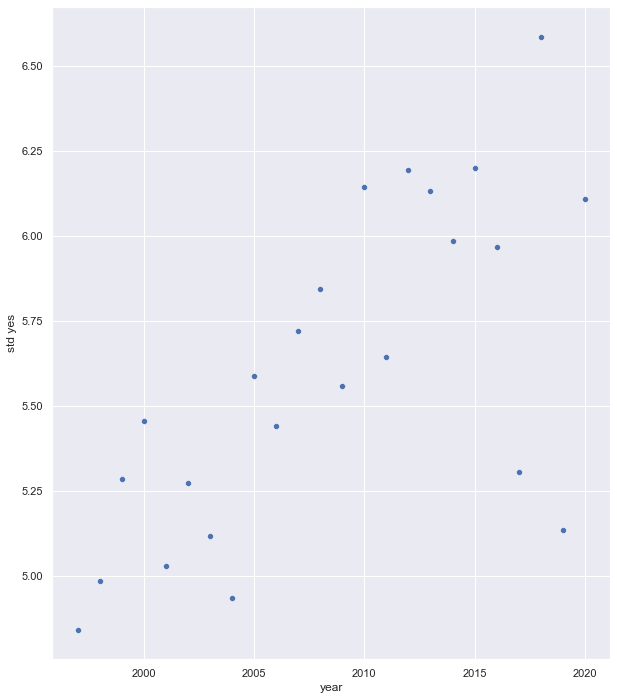

In [371]:
sns.scatterplot(x="year", y="std yes", data=out)
plt.show()

In [356]:
k = wind_all[wind_all["year"] == 1997]
k

observation_station ob_end_time  mean_wind_speed  mean_wind_dir  \
0             cairnwell  1997-01-01        18.625000     115.833333   
1             cairnwell  1997-01-02        21.416667      94.166667   
2             cairnwell  1997-01-03        20.041667      49.166667   
3             cairnwell  1997-01-04         9.416667      38.750000   
4             cairnwell  1997-01-05        16.750000      37.500000   
..                  ...         ...              ...            ...   
360              valley  1997-12-27        16.000000     292.500000   
361              valley  1997-12-28        15.666667     270.416667   
362              valley  1997-12-29         9.750000     178.333333   
363              valley  1997-12-30        23.250000     188.750000   
364              valley  1997-12-31        17.333333     242.916667   

     max_gust_dir  max_gust_speed  year  month  hour  season  \
0      100.000000       26.125000  1997      1     0  winter   
1       88.333333       30.750000  1997      1     0  winter   
2       47.916667       29.250000  1997      1     0  winter   
3       44.583333       15.416667  1997      1     0  winter   
4       43.750000       23.458333  1997      1     0  winter   
..            ...             ...   ...    ...   ...     ...   
360    290.833333       23.708333  1997     12     0  winter   
361    268.750000       23.125000  1997     12     0  winter   
362    179.166667       14.708333  1997     12     0  winter   
363    187.916667       31.541667  1997     12     0  winter   
364    238.750000       25.375000  1997     12     0  winter   

    is_outlier_mean_wind_speed  
0                           no  
1                          yes  
2                           no  
3                           no  
4                           no  
..                         ...  
360                         no  
361                         no  
362                         no  
363                        yes  
364                         no  

[14313 rows x 11 columns]

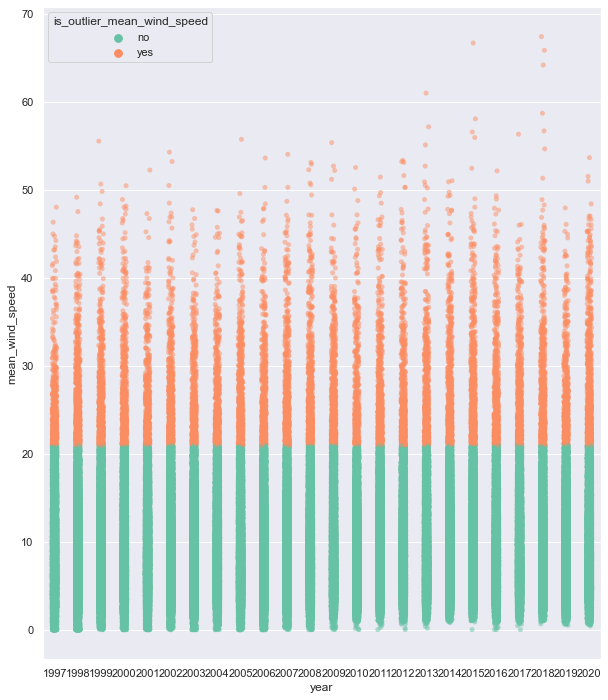

In [366]:
#fig, axes = plt.subplots(1, 2,figsize=(18, 10))

#fig.suptitle('Power Generation vs Weather')

# sns.stripplot(x="mean_wind_speed", 
#               hue="is_outlier_mean_wind_speed", 
#               alpha = 0.5, data=k)
#plt.rcParams['figure.figsize']=(10,12)
#sns.boxplot(y="mean mean_wind_speed", x="month", data=comb_on, ax=axes[1])
#sns.lineplot(x="WeightedPowerGenerationMW", y="ob_end_time", data=comb, ax=axes[0, 1])


sns.stripplot(y="mean_wind_speed", x="year", hue="is_outlier_mean_wind_speed",
                   data=wind_all, palette="Set2", alpha = 0.5)

plt.show()

#### Clean and output csv

In [37]:

wind_out.to_csv(root_local + "wind_out.csv")
wind_all.to_csv(root_local + "wind_all.csv")
wind_all

Unnamed: 0 observation_station ob_end_time  mean_wind_speed  \
0                0           cairnwell  2015-01-01        35.625000   
1                1           cairnwell  2015-01-02        34.541667   
2                2           cairnwell  2015-01-03        28.166667   
3                3           cairnwell  2015-01-04        17.166667   
4                4           cairnwell  2015-01-05        25.166667   
...            ...                 ...         ...              ...   
218597         361         west-freugh  2020-12-27        15.708333   
218598         362         west-freugh  2020-12-28         4.500000   
218599         363         west-freugh  2020-12-29         7.434783   
218600         364         west-freugh  2020-12-30         5.375000   
218601         365         west-freugh  2020-12-31         7.458333   

        mean_wind_dir  max_gust_dir  max_gust_speed  year  month  hour  \
0          229.583333    228.750000       50.875000  2015      1     0   
1          269.166667    272.500000       56.708333  2015      1     0   
2          297.083333    298.333333       40.125000  2015      1     0   
3          239.583333    248.750000       29.583333  2015      1     0   
4          219.583333    227.083333       36.083333  2015      1     0   
...               ...           ...             ...   ...    ...   ...   
218597     248.333333    250.000000       25.625000  2020     12     0   
218598     172.916667    183.333333        8.250000  2020     12     0   
218599     338.260870    310.869565       13.956522  2020     12     0   
218600     280.833333    280.833333        9.791667  2020     12     0   
218601     315.000000    282.916667       14.708333  2020     12     0   

       is_outlier_mean_wind_speed  
0                             yes  
1                             yes  
2                             yes  
3                              no  
4                             yes  
...                           ...  
218597                         no  
218598                         no  
218599                         no  
218600                         no  
218601                         no  

[218602 rows x 11 columns]

### Temperature

#### If the temperature data is set to load via FTP then load it 

In [66]:
#extra set up for loading the data
temp_values =  ["max_air_temp","min_air_temp"]

temp_index = ["observation_station", "historic_county_name","lat","long"]
temp_extra = ["year", "month", "hour"]
temp_mean = pd.DataFrame(columns = temp_index + temp_extra + temp_values)

temp_all_cols =  ["observation_station"] + ["ob_end_time"] + temp_values
temp_all = pd.DataFrame(columns = temp_all_cols)

In [67]:
# root = "ftp://ftp.ceda.ac.uk/badc/ukmo-midas-open/data/uk-mean-wind-obs/dataset-version-202007/"
#Load ftp data into a list
if (load_data):

    ftp.cwd('/badc/ukmo-midas-open/data/uk-daily-temperature-obs/dataset-version-202107/')
    
    temp_list = []
    county = ftp.nlst()

    #county[1:]
    for c in county:
        if ".txt" not in c:
            #print(c)
            station = ftp.nlst(c)
            for s in station:
                if ".txt" not in s:
                    #print(s)
                    #try to get the file from the ftp server, if not carry on the loop
                        #this is because there are config files that can screw up the file reading
                    try:
                        filenames = ftp.nlst(s + '/qc-version-1/')
                        for f in filenames:
                            if any(ext in f for ext in download_years) and ".txt" not in f:
                                #print(s.split("_")[1])
                                if s.split("_")[1] in temp_closest_dst_id_list:
                                    print(f)
                                    # download the file but first create a virtual file object for it
                                    download_file = io.BytesIO()
                                    ftp.retrbinary("RETR {}".format(f), download_file.write)
                                    download_file.seek(0) # after writing go back to the start of the virtual file
                                    obs = pd.read_csv(download_file, skiprows = 90) # read virtual file into pandas

                                    download_file = io.BytesIO()
                                    ftp.retrbinary("RETR {}".format(f), download_file.write)
                                    download_file.seek(0) # after writing go back to the start of the virtual file

                                    info = pd.read_csv(download_file, nrows = 77) # read virtual file into pandas
                                    #print(info)

                                    #adds on any extra info required into the dataset
                                    obs['observation_station'] = info.loc[info["Conventions"] == "observation_station"].iloc[0,2]
    #                                 obs['historic_county_name'] = info.loc[info["Conventions"] == "historic_county_name"].iloc[0,2]
    #                                 obs['lat'] = info.loc[info["Conventions"] == "location"].iloc[0,2]
    #                                 obs['long'] = info.loc[info["Conventions"] == "location"].iloc[0,3]

                                    #print(obs.head())
                                    #print(obs.shape)
                                    t = obs.copy() # copy from list
                                    t = t[t["id_type"] == "DCNN"] #filter for wind data
                                    t = t[temp_all_cols] #reduce columns
                                    t['max_air_temp'] = t.max_air_temp.ffill().add(t.max_air_temp.bfill()).div(2)
                                    t['min_air_temp'] = t.min_air_temp.ffill().add(t.min_air_temp.bfill()).div(2)
                                    #temp_all = temp_all.append(obs)
                                    #print(t.head(2))
                                    print(t.shape)
                                    if t.shape[0] != 0:
                                        t_rsm = t.copy()
                                        t_rsm['ob_end_time'] = pd.to_datetime(t_rsm['ob_end_time'], 
                                                                   format = '%Y-%m-%d %H:%M:%S')       
                                        
                                        t_rsm = t_rsm.set_index("ob_end_time")
                                        #TODO:resample into other types of calculation
                                        t_rsm = t_rsm.groupby(["observation_station"]).resample('D').mean().reset_index()
                                        #print(t_rsm.head(2))
                                        temp_all = temp_all.append(t_rsm)
                    finally:
                        continue
                        

aberdeenshire/00148_balmoral/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_aberdeenshire_00148_balmoral_qcv-1_2015.csv
(729, 4)
aberdeenshire/00148_balmoral/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_aberdeenshire_00148_balmoral_qcv-1_2016.csv
(732, 4)
aberdeenshire/00148_balmoral/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_aberdeenshire_00148_balmoral_qcv-1_2017.csv
(730, 4)
aberdeenshire/00148_balmoral/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_aberdeenshire_00148_balmoral_qcv-1_2018.csv
(730, 4)
aberdeenshire/00148_balmoral/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_aberdeenshire_00148_balmoral_qcv-1_2019.csv
(729, 4)
aberdeenshire/00148_balmoral/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_aberdeenshire_00148_balmoral_qcv-1_2020.csv
(732, 4)
aberdeenshire/00159_fyvie-castle/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_aberdeenshire_00159_fyvie-castle_qcv-1_2015.csv
(730, 4)
aberd

(715, 4)
bedfordshire/00461_bedford/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_bedfordshire_00461_bedford_qcv-1_2019.csv
(706, 4)
bedfordshire/00461_bedford/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_bedfordshire_00461_bedford_qcv-1_2020.csv
(732, 4)
caithness/00032_wick-airport/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_caithness_00032_wick-airport_qcv-1_2015.csv
(731, 4)
caithness/00032_wick-airport/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_caithness_00032_wick-airport_qcv-1_2016.csv
(731, 4)
caithness/00032_wick-airport/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_caithness_00032_wick-airport_qcv-1_2017.csv
(730, 4)
caithness/00032_wick-airport/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_caithness_00032_wick-airport_qcv-1_2018.csv
(700, 4)
caithness/00032_wick-airport/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_caithness_00032_wick-airport_qcv-1_2019.csv
(730, 4)
caithness/00

(730, 4)
cumbria/01070_carlisle/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_cumbria_01070_carlisle_qcv-1_2020.csv
(732, 4)
cumbria/01078_walney-island/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_cumbria_01078_walney-island_qcv-1_2015.csv
(730, 4)
cumbria/01078_walney-island/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_cumbria_01078_walney-island_qcv-1_2016.csv
(731, 4)
cumbria/01078_walney-island/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_cumbria_01078_walney-island_qcv-1_2017.csv
(730, 4)
cumbria/01078_walney-island/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_cumbria_01078_walney-island_qcv-1_2018.csv
(730, 4)
cumbria/01078_walney-island/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_cumbria_01078_walney-island_qcv-1_2019.csv
(730, 4)
cumbria/01078_walney-island/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_cumbria_01078_walney-island_qcv-1_2020.csv
(389, 4)
cumbria/01080_levens-hall/qc

(350, 4)
dyfed/30448_llanfynydd/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_dyfed_30448_llanfynydd_qcv-1_2018.csv
(359, 4)
dyfed/30448_llanfynydd/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_dyfed_30448_llanfynydd_qcv-1_2019.csv
(365, 4)
dyfed/30448_llanfynydd/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_dyfed_30448_llanfynydd_qcv-1_2020.csv
(366, 4)
east-lothian/00262_nunraw-abbey/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_east-lothian_00262_nunraw-abbey_qcv-1_2015.csv
(365, 4)
east-lothian/00262_nunraw-abbey/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_east-lothian_00262_nunraw-abbey_qcv-1_2016.csv
(360, 4)
east-lothian/00262_nunraw-abbey/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_east-lothian_00262_nunraw-abbey_qcv-1_2017.csv
(358, 4)
east-lothian/00262_nunraw-abbey/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_east-lothian_00262_nunraw-abbey_qcv-1_2018.csv
(358, 4)
east-lothian/002

(719, 4)
inverness-shire/00114_drumnadrochit/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_inverness-shire_00114_drumnadrochit_qcv-1_2019.csv
(729, 4)
inverness-shire/00114_drumnadrochit/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_inverness-shire_00114_drumnadrochit_qcv-1_2020.csv
(726, 4)
kent/00757_faversham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_kent_00757_faversham_qcv-1_2015.csv
(365, 4)
kent/00757_faversham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_kent_00757_faversham_qcv-1_2016.csv
(366, 4)
kent/00757_faversham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_kent_00757_faversham_qcv-1_2017.csv
(365, 4)
kent/00757_faversham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_kent_00757_faversham_qcv-1_2018.csv
(365, 4)
kent/00757_faversham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_kent_00757_faversham_qcv-1_2019.csv
(365, 4)
kent/00757_faversham/qc-version-1/midas-open_uk-daily-te

(695, 4)
lancashire/16851_morecambe-no-2/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_lancashire_16851_morecambe-no-2_qcv-1_2016.csv
(732, 4)
lancashire/16851_morecambe-no-2/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_lancashire_16851_morecambe-no-2_qcv-1_2017.csv
(730, 4)
lancashire/16851_morecambe-no-2/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_lancashire_16851_morecambe-no-2_qcv-1_2018.csv
(730, 4)
lancashire/16851_morecambe-no-2/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_lancashire_16851_morecambe-no-2_qcv-1_2019.csv
(730, 4)
lancashire/16851_morecambe-no-2/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_lancashire_16851_morecambe-no-2_qcv-1_2020.csv
(732, 4)
leicestershire/30529_market-bosworth-bosworth-park/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_leicestershire_30529_market-bosworth-bosworth-park_qcv-1_2015.csv
(730, 4)
leicestershire/30529_market-bosworth-bosworth-park/qc-version-1/midas-o

(730, 4)
norfolk/00409_marham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_norfolk_00409_marham_qcv-1_2016.csv
(733, 4)
norfolk/00409_marham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_norfolk_00409_marham_qcv-1_2017.csv
(730, 4)
norfolk/00409_marham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_norfolk_00409_marham_qcv-1_2018.csv
(730, 4)
norfolk/00409_marham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_norfolk_00409_marham_qcv-1_2019.csv
(730, 4)
norfolk/00409_marham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_norfolk_00409_marham_qcv-1_2020.csv
(732, 4)
norfolk/00421_weybourne/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_norfolk_00421_weybourne_qcv-1_2015.csv
(730, 4)
norfolk/00421_weybourne/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_norfolk_00421_weybourne_qcv-1_2016.csv
(732, 4)
norfolk/00421_weybourne/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_norfolk_00421_weybour

(728, 4)
orkney/00023_kirkwall/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_orkney_00023_kirkwall_qcv-1_2020.csv
(732, 4)
perthshire-in-tayside-region/15365_dunbarney-south-hill/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_perthshire-in-tayside-region_15365_dunbarney-south-hill_qcv-1_2015.csv
(360, 4)
perthshire-in-tayside-region/15365_dunbarney-south-hill/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_perthshire-in-tayside-region_15365_dunbarney-south-hill_qcv-1_2016.csv
(360, 4)
perthshire-in-tayside-region/15365_dunbarney-south-hill/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_perthshire-in-tayside-region_15365_dunbarney-south-hill_qcv-1_2017.csv
(358, 4)
perthshire-in-tayside-region/15365_dunbarney-south-hill/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_perthshire-in-tayside-region_15365_dunbarney-south-hill_qcv-1_2018.csv
(365, 4)
perthshire-in-tayside-region/15365_dunbarney-south-hill/qc-version-1/midas-open_uk-d

(732, 4)
west-yorkshire/00534_bramham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_west-yorkshire_00534_bramham_qcv-1_2017.csv
(730, 4)
west-yorkshire/00534_bramham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_west-yorkshire_00534_bramham_qcv-1_2018.csv
(730, 4)
west-yorkshire/00534_bramham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_west-yorkshire_00534_bramham_qcv-1_2019.csv
(730, 4)
west-yorkshire/00534_bramham/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_west-yorkshire_00534_bramham_qcv-1_2020.csv
(732, 4)
west-yorkshire/56958_emley-moor-no-2/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_west-yorkshire_56958_emley-moor-no-2_qcv-1_2015.csv
(730, 4)
west-yorkshire/56958_emley-moor-no-2/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_west-yorkshire_56958_emley-moor-no-2_qcv-1_2016.csv
(732, 4)
west-yorkshire/56958_emley-moor-no-2/qc-version-1/midas-open_uk-daily-temperature-obs_dv-202107_west-yorkshire_56

In [69]:
temp_all.to_csv(root_local + "temp_all.csv")
temp_all

observation_station ob_end_time  max_air_temp  min_air_temp
0                        balmoral  2015-01-01         10.50          7.35
1                        balmoral  2015-01-02          5.35          0.80
2                        balmoral  2015-01-03          2.95          0.50
3                        balmoral  2015-01-04          4.25          0.05
4                        balmoral  2015-01-05          7.40          2.20
..                            ...         ...           ...           ...
361  portpatrick-craigenlee-croft  2020-12-27          7.60          2.50
362  portpatrick-craigenlee-croft  2020-12-28          4.80          0.30
363  portpatrick-craigenlee-croft  2020-12-29          5.80          0.10
364  portpatrick-craigenlee-croft  2020-12-30          5.70          0.50
365  portpatrick-craigenlee-croft  2020-12-31          4.00          0.00

[173013 rows x 4 columns]

### Read CSV if not loading from FTP

In [30]:
#if not load_data:
wind_all = pd.read_csv(root_local + "wind_all.csv")
farm = pd.read_csv(root_local + "farm.csv")

### Power Generation

#### Power Curve Calculations

In [403]:
#Find the percentage of the time that the wind is within the optimal range
#For each time point and station, I calculate the assumed capacity of the 
#turbine 
#gets only relevant stations to make the dataframe smaller
relevant_stations = pd.unique(farm["wind_closest_station"])

pwr_crv = farm.copy()
pwr_crv = pwr_crv[["Site Name","wind_closest_station","temp_closest_station", 'Turbine Capacity (MW)',
                       'Installed Capacity (MWelec)', 'No. of Turbines', 'blade_width', 'Technology Type']]

pwr_crv = pd.merge(wind_all, pwr_crv, left_on="observation_station", 
                   right_on="wind_closest_station", how="left")

pwr_crv["mean_wind_speed_ms"] = pwr_crv["mean_wind_speed"] * 0.514444

def turbine_power(wind_speed_ms, turbine_capacity = 3.5,
                    blade_width = 52, 
                    betz_lim = 0.4, air_density = 1.23,
                    cut_out_wind_speed_ms = 25,
                    cut_in_wind_speed_ms = 4,
                    rating_speed_ms = 12):
  #https://www.raeng.org.uk/publications/other/23-wind-turbine
  #https://link.springer.com/article/10.1007/s40095-020-00352-2
  if (wind_speed_ms >= cut_in_wind_speed_ms) and (wind_speed_ms <= cut_out_wind_speed_ms):
    #holds wind speed constant if the speed is over the rating speed
    if (wind_speed_ms >= rating_speed_ms):
      wind_speed_ms = rating_speed_ms
    blade_area = math.pi * blade_width ** 2
    pwr_mw = (0.5 * air_density * blade_area * wind_speed_ms ** 3 * betz_lim)/1000000
    if pwr_mw >= turbine_capacity:
        pwr_mw = turbine_capacity
  else:
      pwr_mw = 0
  return(pwr_mw)

#test the turbine generation function 
# =============================================================================
# pwr_test = pd.DataFrame([(x, y, z) for x in range(18,19) for y in range(1,9) for z in range(50,80,5)], 
#                          columns = ["wind", "cap", "tst"])
# pwr_test['pwr_gen'] = pwr_test.apply(lambda row: turbine_power(row['wind'], row['cap'], 
#                                                                blade_width = row['tst']), axis=1)
# 
# turbine_power(wind_speed_ms = 18, turbine_capacity = 7,
#                     blade_width = 52, rating_speed_ms = 12)
# 
# plt.plot(pwr_test['wind'], pwr_test['pwr_gen'])
# plt.show()
# =============================================================================

pwr_crv['power_generation'] = pwr_crv.apply(lambda row: turbine_power(row['mean_wind_speed_ms'], 
                                                          row['Turbine Capacity (MW)'],
                                                          row['blade_width']), axis=1)

pwr_crv["farm_generation"] = pwr_crv["power_generation"] * pwr_crv['No. of Turbines']

pwr_crv["generation_prop"] = pwr_crv["farm_generation"] / pwr_crv['Installed Capacity (MWelec)'] 

pwr_crv.to_csv(root_local + "power_curve.csv")
pwr_crv

observation_station ob_end_time  mean_wind_speed  mean_wind_dir  \
0                 cairnwell  1997-01-01        18.625000     115.833333   
1                 cairnwell  1997-01-01        18.625000     115.833333   
2                 cairnwell  1997-01-01        18.625000     115.833333   
3                 cairnwell  1997-01-01        18.625000     115.833333   
4                 cairnwell  1997-01-02        21.416667      94.166667   
...                     ...         ...              ...            ...   
3092305              valley  2009-12-30        23.166667      62.083333   
3092306              valley  2009-12-30        23.166667      62.083333   
3092307              valley  2009-12-31        12.458333      54.166667   
3092308              valley  2009-12-31        12.458333      54.166667   
3092309              valley  2009-12-31        12.458333      54.166667   

         max_gust_dir  max_gust_speed  year  month  hour  season  ...  \
0          100.000000       26.125000  1997      1     0  winter  ...   
1          100.000000       26.125000  1997      1     0  winter  ...   
2          100.000000       26.125000  1997      1     0  winter  ...   
3          100.000000       26.125000  1997      1     0  winter  ...   
4           88.333333       30.750000  1997      1     0  winter  ...   
...               ...             ...   ...    ...   ...     ...  ...   
3092305     62.916667       35.541667  2009     12     0  winter  ...   
3092306     62.916667       35.541667  2009     12     0  winter  ...   
3092307     54.583333       19.916667  2009     12     0  winter  ...   
3092308     54.583333       19.916667  2009     12     0  winter  ...   
3092309     54.583333       19.916667  2009     12     0  winter  ...   

               temp_closest_station Turbine Capacity (MW)  \
0        blairgowrie-rosemount-farm                  2.30   
1                          balmoral                  2.30   
2        blairgowrie-rosemount-farm                  2.30   
3                   bridge-of-cally                  2.05   
4        blairgowrie-rosemount-farm                  2.30   
...                             ...                   ...   
3092305          anglesey-llyn-alaw                  2.25   
3092306                      amlwch                  2.30   
3092307                      amlwch                  0.40   
3092308          anglesey-llyn-alaw                  2.25   
3092309                      amlwch                  2.30   

        Installed Capacity (MWelec) No. of Turbines  blade_width  \
0                               9.2             4.0           52   
1                               6.9             3.0           52   
2                              36.8            16.0           52   
3                              14.4             7.0           52   
4                               9.2             4.0           52   
...                             ...             ...          ...   
3092305                        20.4             9.0           52   
3092306                         4.6             2.0           52   
3092307                         5.6            14.0           52   
3092308                        20.4             9.0           52   
3092309                         4.6             2.0           52   

         Technology Type  mean_wind_speed_ms  power_generation  \
0           Wind Onshore            9.581520          1.838209   
1           Wind Onshore            9.581520          1.838209   
2           Wind Onshore            9.581520          1.838209   
3           Wind Onshore            9.581520          1.838209   
4           Wind Onshore           11.017676          2.300000   
...                  ...                 ...               ...   
3092305     Wind Onshore           11.917953          2.250000   
3092306     Wind Onshore           11.917953          2.300000   
3092307     Wind Onshore            6.409115          0.400000   
3092308     Wind Ons

### Pull in BMRS API data

https://www.elexon.co.uk/documents/training-guidance/bsc-guidance-notes/bmrs-api-and-data-push-user-guide-2/

https://www.bmreports.com/bmrs/?q=help/site-help#15

In [12]:
gen_dates = [d.strftime('%Y-%m-%d') for d in pd.date_range('2015-01-01','2020-12-31')]

url1="https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate="
url2="&Period=*&ServiceType=csv"

gen_list = []

for date in gen_dates:
    try:
        url = url1 + date +  url2
        gen_list.append(pd.read_csv(url, skiprows=4))
        print(url)
    finally:
        continue


https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-01-01&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-01-02&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-01-03&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-01-04&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-01-05&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-01-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-01-07&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-01-08&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-01-09

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-03-15&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-03-16&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-03-17&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-03-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-03-19&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-03-20&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-03-21&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-03-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-03-23

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-05-26&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-05-27&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-05-28&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-05-29&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-05-30&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-05-31&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-06-01&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-06-02&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-06-03

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-08-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-08-07&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-08-08&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-08-09&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-08-10&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-08-11&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-08-12&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-08-13&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-08-14

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-10-17&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-10-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-10-19&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-10-20&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-10-21&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-10-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-10-23&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-10-24&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-10-25

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-12-29&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-12-30&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2015-12-31&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-01-02&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-01-03&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-01-04&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-01-05&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-01-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-01-07

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-03-11&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-03-12&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-03-13&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-03-14&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-03-15&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-03-16&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-03-17&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-03-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-03-19

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-05-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-05-23&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-05-24&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-05-25&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-05-26&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-05-27&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-05-28&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-05-29&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-05-30

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-08-02&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-08-03&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-08-04&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-08-05&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-08-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-08-07&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-08-08&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-08-09&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-08-10

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-10-13&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-10-14&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-10-15&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-10-16&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-10-17&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-10-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-10-19&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-10-20&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-10-21

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-12-24&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-12-25&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-12-26&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-12-27&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-12-28&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-12-29&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-12-30&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2016-12-31&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-01-01

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-03-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-03-07&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-03-08&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-03-09&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-03-10&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-03-11&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-03-12&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-03-13&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-03-14

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-05-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-05-19&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-05-20&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-05-21&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-05-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-05-23&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-05-24&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-05-25&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-05-26

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-07-29&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-07-30&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-07-31&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-08-01&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-08-02&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-08-03&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-08-04&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-08-05&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-08-06

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-10-09&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-10-10&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-10-11&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-10-12&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-10-13&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-10-14&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-10-15&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-10-16&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-10-17

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-12-21&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-12-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-12-23&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-12-24&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-12-25&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-12-26&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-12-27&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-12-28&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2017-12-29

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-03-04&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-03-05&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-03-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-03-07&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-03-08&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-03-09&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-03-10&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-03-12&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-03-13

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-05-17&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-05-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-05-19&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-05-20&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-05-21&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-05-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-05-23&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-05-24&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-05-25

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-07-28&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-07-29&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-07-30&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-07-31&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-08-01&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-08-02&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-08-03&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-08-04&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-08-05

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-10-09&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-10-10&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-10-11&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-10-12&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-10-13&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-10-14&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-10-15&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-10-16&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-10-17

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-12-21&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-12-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-12-23&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-12-24&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-12-25&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-12-26&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-12-27&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-12-28&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2018-12-29

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-03-03&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-03-04&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-03-05&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-03-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-03-07&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-03-08&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-03-09&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-03-10&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-03-11

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-05-15&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-05-16&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-05-17&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-05-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-05-19&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-05-20&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-05-21&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-05-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-05-23

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-07-26&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-07-27&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-07-28&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-07-29&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-07-30&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-07-31&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-08-01&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-08-02&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-08-03

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-10-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-10-07&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-10-08&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-10-09&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-10-10&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-10-11&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-10-12&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-10-13&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-10-14

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-12-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-12-19&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-12-20&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-12-21&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-12-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-12-23&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-12-24&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-12-25&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2019-12-26

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-02-28&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-02-29&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-03-01&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-03-02&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-03-03&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-03-04&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-03-05&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-03-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-03-07

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-05-11&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-05-12&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-05-13&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-05-14&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-05-15&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-05-16&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-05-17&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-05-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-05-19

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-07-22&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-07-23&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-07-24&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-07-25&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-07-26&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-07-27&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-07-28&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-07-29&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-07-30

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-10-02&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-10-03&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-10-04&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-10-05&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-10-06&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-10-07&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-10-08&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-10-09&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-10-10

https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-12-13&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-12-14&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-12-15&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-12-16&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-12-17&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-12-18&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-12-19&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-12-20&Period=*&ServiceType=csv
https://api.bmreports.com/BMRS/B1630/V1?APIKey=8eim6o3ts4kvb3x&SettlementDate=2020-12-21

In [15]:
gen_all = pd.concat(gen_list)
gen_all = gen_all[gen_all["*Time Series ID"] != "<EOF>"]
gen_all = gen_all[gen_all["Business Type"] == "Wind generation"]
gen_all = gen_all[["Business Type", "Power System Resource  Type", 
               "Settlement Date", "Quantity ", "Settlement Period"]]
gen_all.columns = gen_all.columns.str.replace(' ', '')
#print(gen_all.isna().sum())

gen_des = gen_all.describe().reset_index()
gen_des

index       Quantity  SettlementPeriod
0  count  209550.000000     209550.000000
1   mean    2228.849998         24.499652
2    std    4129.216988         13.849444
3    min     -94.817000          1.000000
4    25%     863.967250         13.000000
5    50%    1840.990500         24.000000
6    75%    3247.945500         36.000000
7    max  602104.612000         50.000000

In [16]:
#converts minus numbers to 0 as generation cannot be negative
gen_all["Quantity"] = np.where(gen_all["Quantity"] < 0, 0, gen_all["Quantity"])

#takes awa most extreme values that are orders of magnitude above the rest 
gen_std = gen_des[gen_des["index"] == "std"]["Quantity"][2]
gen_mn = gen_des[gen_des["index"] == "mean"]["Quantity"][1]
gen_upper = gen_mn + gen_std * 2

print([gen_std, gen_mn, gen_upper])

gen_all['is_outlier_generation'] = np.where((gen_all['Quantity'] > gen_upper), "yes", "no")
#get rid of outliers and use the other settlement periods in that day for averages
gen_all.to_csv(root_local + "gen_all.csv")
gen_in = gen_all[gen_all['is_outlier_generation'] == "no"]
gen_in.to_csv(root_local + "gen_in.csv")

[4129.21698838781, 2228.8499980434517, 10487.28397481907]


In [484]:
gen_in.sort_values("Quantity", ascending = False)

BusinessType PowerSystemResourceType SettlementDate  Quantity  \
57   Wind generation            Wind Onshore     2018-03-17  8353.058   
54   Wind generation            Wind Onshore     2018-03-17  8327.636   
63   Wind generation            Wind Onshore     2018-03-17  8303.418   
66   Wind generation            Wind Onshore     2018-03-17  8297.216   
72   Wind generation            Wind Onshore     2018-03-17  8260.129   
..               ...                     ...            ...       ...   
136  Wind generation           Wind Offshore     2015-05-09     0.000   
135  Wind generation            Wind Onshore     2015-05-09     0.000   
139  Wind generation           Wind Offshore     2015-05-08     0.000   
138  Wind generation            Wind Onshore     2015-05-08     0.000   
0    Wind generation            Wind Onshore     2015-01-01     0.000   

     SettlementPeriod is_outlier_generation  
57               29.0                    no  
54               30.0                    no  
63               27.0                    no  
66               26.0                    no  
72               24.0                    no  
..                ...                   ...  
136               3.0                    no  
135               3.0                    no  
139               2.0                    no  
138               2.0                    no  
0                48.0                    no  

[209340 rows x 6 columns]

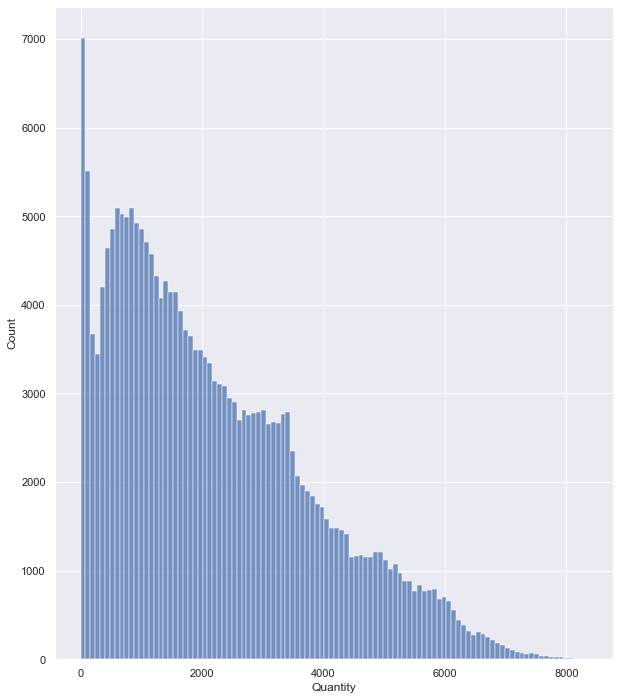

In [485]:
sns.histplot(data=gen_in, x="Quantity")
plt.show()

### Put everything together

In [17]:
#if not load_data:   
temp_all = pd.read_csv(root_local + "temp_all.csv")
pwr_crv = pd.read_csv(root_local + "power_curve.csv")
gen_in = pd.read_csv(root_local + "gen_in.csv")
wind_out = pd.read_csv(root_local + "wind_out.csv")

In [18]:
tur = pwr_crv.pivot_table(values=["Turbine Capacity (MW)",
                                                "Installed Capacity (MWelec)",
                                               "No. of Turbines",
                                               "blade_width"],index=["ob_end_time","Technology Type"],
                         aggfunc=["sum"]).reset_index()
tur.columns = [' '.join(col).strip() for col in tur.columns.values]
tur['ob_end_time'] = pd.to_datetime(tur['ob_end_time'])
tur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17532 entries, 0 to 17531
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ob_end_time                      17532 non-null  datetime64[ns]
 1   Technology Type                  17532 non-null  object        
 2   sum Installed Capacity (MWelec)  17532 non-null  float64       
 3   sum No. of Turbines              17532 non-null  float64       
 4   sum Turbine Capacity (MW)        17532 non-null  float64       
 5   sum blade_width                  17532 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 821.9+ KB


In [25]:
wind_piv = pwr_crv.pivot_table(values=wind_values,index=["ob_end_time","Technology Type"],
                         aggfunc=["sum", "mean", "std", "var"]).reset_index()
wind_piv.columns = [' '.join(col).strip() for col in wind_piv.columns.values]
wind_piv['ob_end_time'] = pd.to_datetime(wind_piv['ob_end_time'])
wind_piv.info()
#wind_piv['ob_end_time'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17532 entries, 0 to 17531
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ob_end_time           17532 non-null  datetime64[ns]
 1   Technology Type       17532 non-null  object        
 2   sum max_gust_dir      17532 non-null  float64       
 3   sum max_gust_speed    17532 non-null  float64       
 4   sum mean_wind_dir     17532 non-null  float64       
 5   sum mean_wind_speed   17532 non-null  float64       
 6   mean max_gust_dir     17532 non-null  float64       
 7   mean max_gust_speed   17532 non-null  float64       
 8   mean mean_wind_dir    17532 non-null  float64       
 9   mean mean_wind_speed  17532 non-null  float64       
 10  std max_gust_dir      17532 non-null  float64       
 11  std max_gust_speed    17532 non-null  float64       
 12  std mean_wind_dir     17532 non-null  float64       
 13  std mean_wind_sp

In [70]:
temp_piv = farm.copy()
temp_piv = temp_piv[["Site Name","wind_closest_station","temp_closest_station", 'Turbine Capacity (MW)',
                       'Installed Capacity (MWelec)', 'No. of Turbines', 'blade_width', 'Technology Type']]

temp_piv = pd.merge(temp_all, temp_piv, left_on="observation_station", 
                   right_on="wind_closest_station", how="left")

temp_piv = temp_piv.pivot_table(values=temp_values,index=["ob_end_time","Technology Type"],
                         aggfunc=[ "mean", "std"]).reset_index()
temp_piv.columns = [' '.join(col).strip() for col in temp_piv.columns.values]
temp_piv['ob_end_time'] = pd.to_datetime(temp_piv['ob_end_time'])
temp_piv.info()
temp_piv['ob_end_time'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ob_end_time        4384 non-null   datetime64[ns]
 1   Technology Type    4384 non-null   object        
 2   mean max_air_temp  4384 non-null   float64       
 3   mean min_air_temp  4384 non-null   float64       
 4   std max_air_temp   4384 non-null   float64       
 5   std min_air_temp   4384 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 205.6+ KB


array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', ...,
       '2020-12-29T00:00:00.000000000', '2020-12-30T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [28]:
gen_day = gen_in.pivot_table(index=["SettlementDate","PowerSystemResourceType"],
                          values="Quantity", aggfunc=sum).reset_index()
gen_day = gen_day.rename(columns={"SettlementDate":"ob_end_time","PowerSystemResourceType": "Technology Type",
                                  "Quantity": "PowerGenerationMW"})
gen_day['ob_end_time'] = pd.to_datetime(gen_day['ob_end_time'])
gen_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ob_end_time        4380 non-null   datetime64[ns]
 1   Technology Type    4380 non-null   object        
 2   PowerGenerationMW  4380 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 102.8+ KB


In [71]:
comb = pd.merge(gen_day, wind_piv, right_on=["ob_end_time","Technology Type"], 
               left_on=["ob_end_time","Technology Type"], how = "inner")

# comb = pd.merge(comb, tur, right_on=["ob_end_time","Technology Type"], 
#                left_on=["ob_end_time","Technology Type"], how = "inner")

comb = pd.merge(comb, temp_piv, right_on=["ob_end_time","Technology Type"], 
               left_on=["ob_end_time","Technology Type"], how = "left")

# comb["avg_turbine_capacity"] = comb["sum Installed Capacity (MWelec)"] / comb["sum No. of Turbines"]
# comb["WeightedPowerGenerationMW"] = comb["PowerGenerationMW"] / comb["avg_turbine_capacity"] 

comb["year"] = pd.DatetimeIndex(comb['ob_end_time']).year
comb["month"] = pd.DatetimeIndex(comb['ob_end_time']).month
comb["hour"] = pd.DatetimeIndex(comb['ob_end_time']).hour 
comb["day"] = pd.DatetimeIndex(comb['ob_end_time']).day 

# comb = pd.merge(comb, wind_out[["year", "extreme_wind"]], right_on=["year"], 
#                left_on=["year"], how = "left")



#comb["season"] = np.select([month <= 3, month <= 9, month <= 12], ["winter", "summer", "winter"] )

comb.to_csv("combined.csv")
comb

ob_end_time Technology Type  PowerGenerationMW  sum max_gust_dir  \
0     2015-01-01   Wind Offshore           6542.735       4061.250000   
1     2015-01-01    Wind Onshore          34174.872      71767.500000   
2     2015-01-02   Wind Offshore           6411.548       5012.500000   
3     2015-01-02    Wind Onshore          32388.259      87319.583333   
4     2015-01-03   Wind Offshore           2569.678       4787.500000   
...          ...             ...                ...               ...   
4375  2020-12-29    Wind Onshore         108245.090      90042.916667   
4376  2020-12-30   Wind Offshore         102011.768       4804.166667   
4377  2020-12-30    Wind Onshore          76006.310      79087.916667   
4378  2020-12-31   Wind Offshore          80991.621       4719.166667   
4379  2020-12-31    Wind Onshore         121907.117      77212.083333   

      sum max_gust_speed  sum mean_wind_dir  sum mean_wind_speed  \
0             505.166667        4017.083333           302.666667   
1            9979.500000       71334.583333          6265.791667   
2             565.208333        4980.416667           333.666667   
3           10079.083333       86741.250000          5927.958333   
4             285.000000        4561.250000           169.125000   
...                  ...                ...                  ...   
4375         4739.069444       90225.833333          2648.458333   
4376          183.833333        4822.500000           105.291667   
4377         3200.000000       76870.000000          1805.250000   
4378          226.541667        4611.666667           135.875000   
4379         3779.291667       77361.666667          2132.750000   

      mean max_gust_dir  mean max_gust_speed  mean mean_wind_dir  ...  \
0            213.750000            26.587719          211.425439  ...   
1            213.593750            29.700893          212.305308  ...   
2            263.815789            29.747807          262.127193  ...   
3            259.879712            29.997272          258.158482  ...   
4            251.973684            15.000000          240.065789  ...   
...                 ...                  ...                 ...  ...   
4375         267.984871            14.104373          268.529266  ...   
4376         252.850877             9.675439          253.815789  ...   
4377         242.600971             9.815951          235.797546  ...   
4378         248.377193            11.923246          242.719298  ...   
4379         236.846881            11.592919          237.305726  ...   

      var mean_wind_dir  var mean_wind_speed  mean max_air_temp  \
0             91.711339             7.198506           9.904167   
1            166.771165            41.170382          10.563609   
2             13.558926            20.498914           9.929167   
3            121.061272            49.371736           8.329348   
4            758.955694             9.874462           5.593750   
...                 ...                  ...                ...   
4375        4108.227458            17.940478           3.449847   
4376         665.591496             1.630208           3.233333   
4377        1901.492305             6.800549           2.446177   
4378        6588.529483             9.785534           1.945833   
4379        5353.854235            18.241043           2.690367   

      mean min_air_temp  std max_air_temp  std min_air_temp  year  month  \
0              6.693750          1.099102          1.679824  2015      1   
1              7.311491          0.949228          1.336706  2015      1   
2              5.116667          1.701976          1.639503  2015      1   
3              3.313043          2.144917          1.701356  2015      1   
4              2.514583          1.426253          0.835032  2015      1   
...                 ...               ...               ...   ...    ...   
4375           0.490673          1.471006          1.348134  2020     12   
4376          -0.0166

In [62]:
k = pd.merge(gen_day, wind_piv, right_on=["ob_end_time","Technology Type"], 
               left_on=["ob_end_time","Technology Type"], how = "inner")

comb.groupby("year").count()

ob_end_time  Technology Type  PowerGenerationMW  sum max_gust_dir  \
year                                                                      
2015         1460             1460               1460              1460   
2016         1460             1460               1460              1460   
2017         1460             1460               1460              1460   
2018         1456             1456               1456              1456   
2019          730              730                730               730   
2020          732              732                732               732   

      sum max_gust_speed  sum mean_wind_dir  sum mean_wind_speed  \
year                                                               
2015                1460               1460                 1460   
2016                1460               1460                 1460   
2017                1460               1460                 1460   
2018                1456               1456                 1456   
2019                 730                730                  730   
2020                 732                732                  732   

      mean max_gust_dir  mean max_gust_speed  mean mean_wind_dir  ...  \
year                                                              ...   
2015               1460                 1460                1460  ...   
2016               1460                 1460                1460  ...   
2017               1460                 1460                1460  ...   
2018               1456                 1456                1456  ...   
2019                730                  730                 730  ...   
2020                732                  732                 732  ...   

      sum blade_width  mean max_air_temp  mean min_air_temp  std max_air_temp  \
year                                                                            
2015             1460               1460               1460              1460   
2016             1460               1460               1460              1460   
2017             1460               1460               1460              1460   
2018             1456               1456               1456              1456   
2019              730                730                730               730   
2020              732                732                732               732   

      std min_air_temp  avg_turbine_capacity  WeightedPowerGenerationMW  \
year                                                                      
2015              1460                  1460                       1460   
2016              1460                  1460                       1460   
2017              1460                  1460                       1460   
2018              1456                  1456                       1456   
2019               730                   730                        730   
2020               732                   732                        732   

      month  hour   day  
year                     
2015   1460  1460  1460  
2016   1460  1460  1460  
2017   1460  1460  1460  
2018   1456  1456  1456  
2019    730   730   730  
2020    732   732   732  

[6 rows x 32 columns]

In [61]:
comb

ob_end_time Technology Type  PowerGenerationMW  sum max_gust_dir  \
0     2015-01-01   Wind Offshore           6542.735       4061.250000   
1     2015-01-01   Wind Offshore           6542.735       4061.250000   
2     2015-01-01    Wind Onshore          34174.872      71767.500000   
3     2015-01-01    Wind Onshore          34174.872      71767.500000   
4     2015-01-02   Wind Offshore           6411.548       5012.500000   
...          ...             ...                ...               ...   
7293  2020-12-29    Wind Onshore         108245.090      90042.916667   
7294  2020-12-30   Wind Offshore         102011.768       4804.166667   
7295  2020-12-30    Wind Onshore          76006.310      79087.916667   
7296  2020-12-31   Wind Offshore          80991.621       4719.166667   
7297  2020-12-31    Wind Onshore         121907.117      77212.083333   

      sum max_gust_speed  sum mean_wind_dir  sum mean_wind_speed  \
0             505.166667        4017.083333           302.666667   
1             505.166667        4017.083333           302.666667   
2            9979.500000       71334.583333          6265.791667   
3            9979.500000       71334.583333          6265.791667   
4             565.208333        4980.416667           333.666667   
...                  ...                ...                  ...   
7293         4739.069444       90225.833333          2648.458333   
7294          183.833333        4822.500000           105.291667   
7295         3200.000000       76870.000000          1805.250000   
7296          226.541667        4611.666667           135.875000   
7297         3779.291667       77361.666667          2132.750000   

      mean max_gust_dir  mean max_gust_speed  mean mean_wind_dir  ...  \
0            213.750000            26.587719          211.425439  ...   
1            213.750000            26.587719          211.425439  ...   
2            213.593750            29.700893          212.305308  ...   
3            213.593750            29.700893          212.305308  ...   
4            263.815789            29.747807          262.127193  ...   
...                 ...                  ...                 ...  ...   
7293         267.984871            14.104373          268.529266  ...   
7294         252.850877             9.675439          253.815789  ...   
7295         242.600971             9.815951          235.797546  ...   
7296         248.377193            11.923246          242.719298  ...   
7297         236.846881            11.592919          237.305726  ...   

      mean max_air_temp  mean min_air_temp  std max_air_temp  \
0              9.904167           6.693750          1.099102   
1              9.904167           6.693750          1.099102   
2             10.563609           7.311491          0.949228   
3             10.563609           7.311491          0.949228   
4              9.929167           5.116667          1.701976   
...                 ...                ...               ...   
7293           3.449847           0.490673          1.471006   
7294           3.233333          -0.016667          1.038986   
7295           2.446177          -0.839144          1.350951   
7296           1.945833          -1.539583          2.210691   
7297           2.690367          -1.125382          2.043959   

      std min_air_temp  avg_turbine_capacity  WeightedPowerGenerationMW  year  \
0             1.679824              4.312405                1517.189342  2015   
1             1.679824              4.312405                1517.189342  2015   
2             1.336706              1.831000               18664.594211  2015   
3             1.336706              1.831000               18664.594211  2015   
4             1.639503              4.312405                1486.768498  2015   
...                ...                   ...                        ...   ...   
7293          1.348134              1.823090               59374.527727  2020   
7294          0.7

### Visualisation

In [54]:
comb = pd.read_csv(root_local + "combined.csv")
comb_on = comb[comb["Technology Type"] == "Wind Onshore"]
comb_off = comb[comb["Technology Type"] == "Wind Offshore"]
comb.head(2)

Unnamed: 0 ob_end_time Technology Type  PowerGenerationMW  \
0           0  2015-01-01   Wind Offshore           6542.735   
1           1  2015-01-01    Wind Onshore          34174.872   

   sum max_gust_dir  sum max_gust_speed  sum mean_wind_dir  \
0           4061.25          505.166667        4017.083333   
1          71767.50         9979.500000       71334.583333   

   sum mean_wind_speed  mean max_gust_dir  mean max_gust_speed  ...  \
0           302.666667          213.75000            26.587719  ...   
1          6265.791667          213.59375            29.700893  ...   

   mean min_air_temp  std max_air_temp  std min_air_temp  \
0           6.693750          1.099102          1.679824   
1           7.311491          0.949228          1.336706   

   avg_turbine_capacity  WeightedPowerGenerationMW  year  month  hour  day  \
0              4.312405                1517.189342  2015      1     0    1   
1              1.831000               18664.594211  2015      1     0    1   

   extreme_wind  
0           yes  
1           yes  

[2 rows x 35 columns]

#### Combined

In [99]:
comb_on["ob_end_time"]

1      2019-01-01
3      2019-01-02
5      2019-01-03
7      2019-01-04
9      2019-01-05
          ...    
721    2019-12-27
723    2019-12-28
725    2019-12-29
727    2019-12-30
729    2019-12-31
Name: ob_end_time, Length: 365, dtype: object

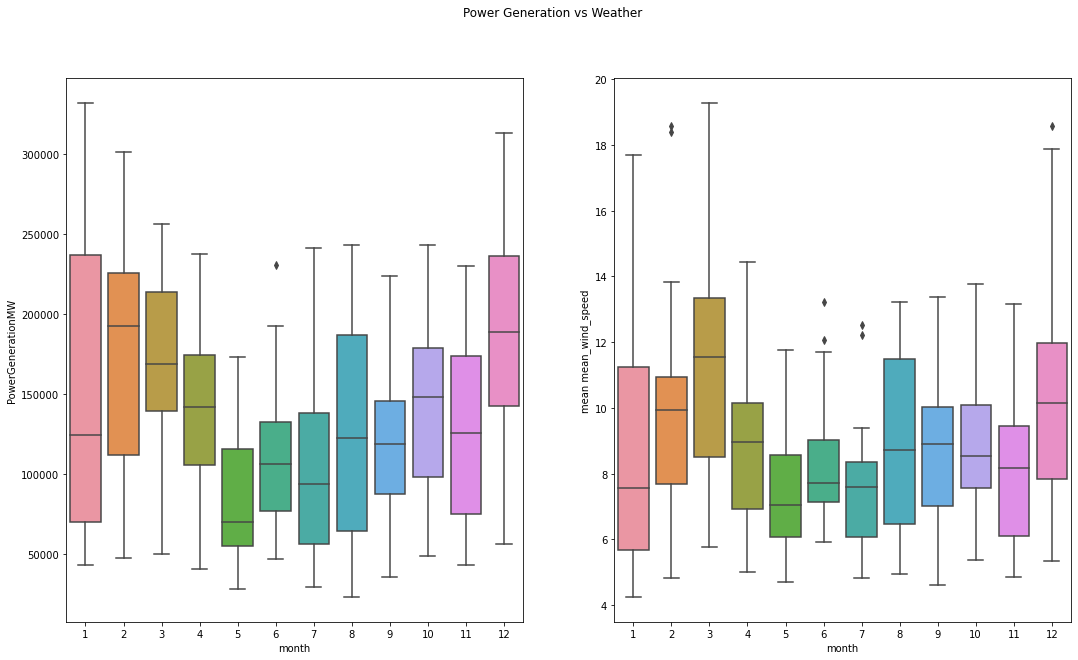

In [52]:
fig, axes = plt.subplots(1, 2,figsize=(18, 10))

fig.suptitle('Power Generation vs Weather')

sns.boxplot(y="PowerGenerationMW", x="month", data=comb_on, ax=axes[0])
sns.boxplot(y="mean mean_wind_speed", x="month", data=comb_on, ax=axes[1])
#sns.lineplot(x="WeightedPowerGenerationMW", y="ob_end_time", data=comb, ax=axes[0, 1])

plt.show()

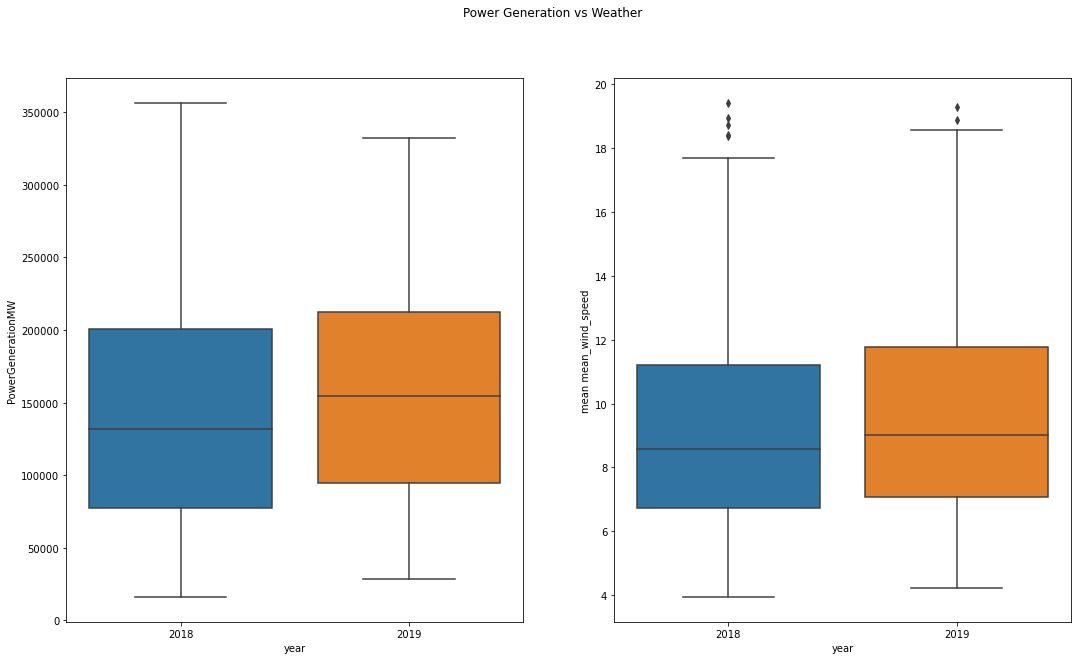

In [56]:
fig, axes = plt.subplots(1, 2,figsize=(18, 10))

fig.suptitle('Power Generation vs Weather')

sns.boxplot(y="PowerGenerationMW", x="year", data=comb_on, ax=axes[0])
sns.boxplot(y="mean mean_wind_speed", x="year", data=comb_on, ax=axes[1])
#sns.lineplot(x="WeightedPowerGenerationMW", y="ob_end_time", data=comb, ax=axes[0, 1])

plt.show()

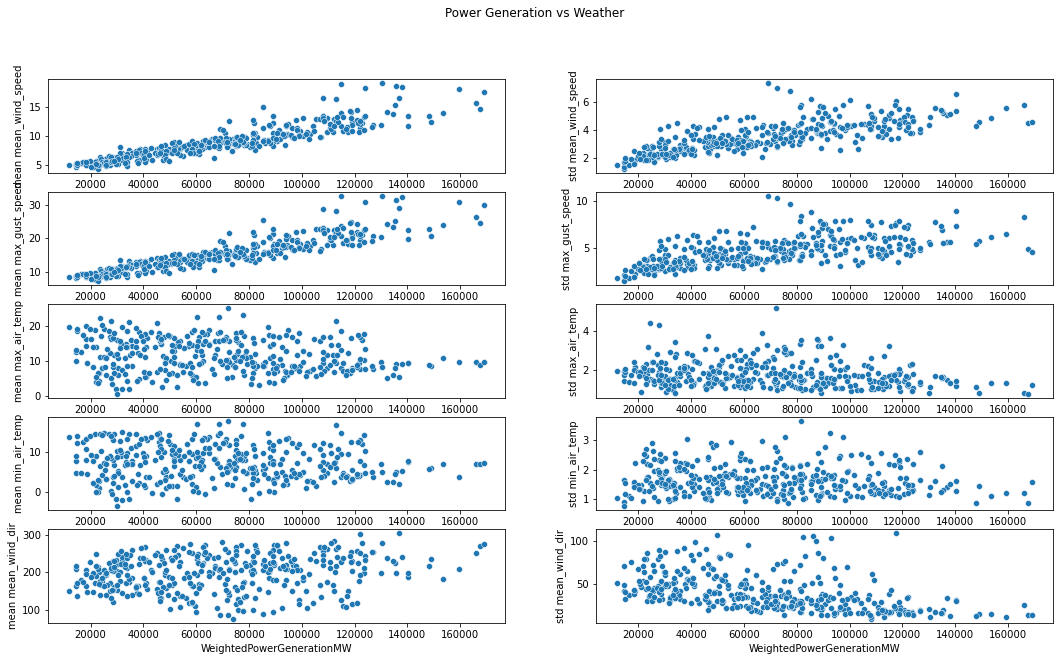

In [90]:
fig, axes = plt.subplots(5, 2, figsize=(18, 10))

fig.suptitle('Power Generation vs Weather')

sns.scatterplot(x="WeightedPowerGenerationMW", y="mean mean_wind_speed", data=comb_on, ax=axes[0, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std mean_wind_speed", data=comb_on, ax=axes[0, 1])
sns.scatterplot(x="WeightedPowerGenerationMW", y="mean max_gust_speed", data=comb_on, ax=axes[1, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std max_gust_speed", data=comb_on, ax=axes[1, 1])
sns.scatterplot(x="WeightedPowerGenerationMW", y="mean max_air_temp", data=comb_on, ax=axes[2, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std max_air_temp", data=comb_on, ax=axes[2, 1])
sns.scatterplot(x="WeightedPowerGenerationMW", y="mean min_air_temp", data=comb_on, ax=axes[3, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std min_air_temp", data=comb_on, ax=axes[3, 1])
sns.scatterplot(x="WeightedPowerGenerationMW", y="mean mean_wind_dir", data=comb_on, ax=axes[4, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std mean_wind_dir", data=comb_on, ax=axes[4, 1])

plt.show()

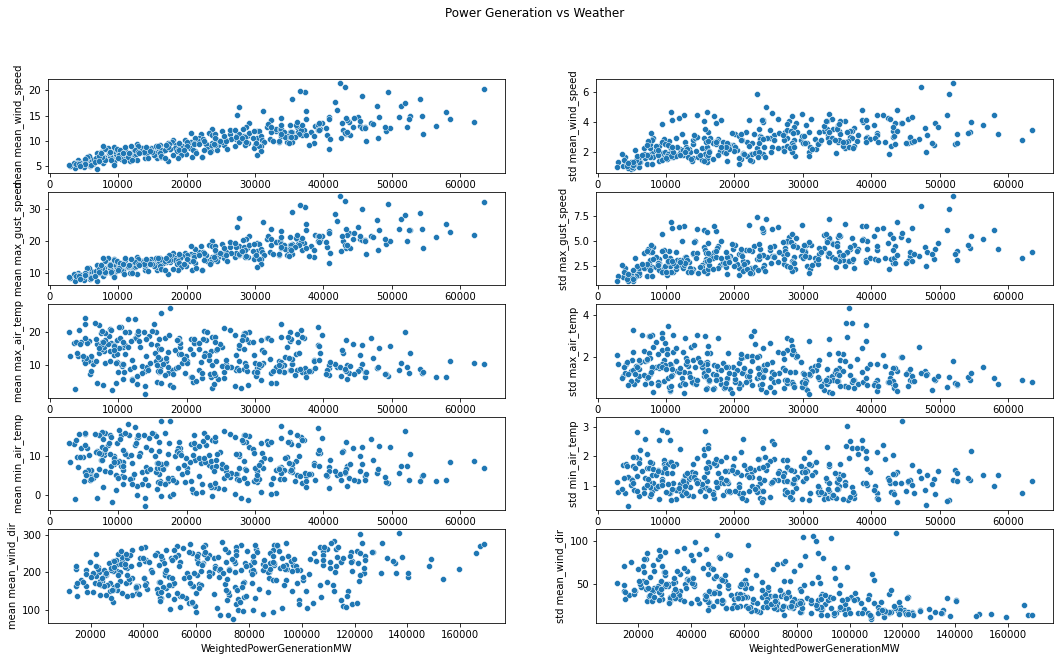

In [91]:
fig, axes = plt.subplots(5, 2, figsize=(18, 10))

fig.suptitle('Power Generation vs Weather')

sns.scatterplot(x="WeightedPowerGenerationMW", y="mean mean_wind_speed", data=comb_off, ax=axes[0, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std mean_wind_speed", data=comb_off, ax=axes[0, 1])
sns.scatterplot(x="WeightedPowerGenerationMW", y="mean max_gust_speed", data=comb_off, ax=axes[1, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std max_gust_speed", data=comb_off, ax=axes[1, 1])
sns.scatterplot(x="WeightedPowerGenerationMW", y="mean max_air_temp", data=comb_off, ax=axes[2, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std max_air_temp", data=comb_off, ax=axes[2, 1])
sns.scatterplot(x="WeightedPowerGenerationMW", y="mean min_air_temp", data=comb_off, ax=axes[3, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std min_air_temp", data=comb_off, ax=axes[3, 1])
sns.scatterplot(x="WeightedPowerGenerationMW", y="mean mean_wind_dir", data=comb_on, ax=axes[4, 0])
sns.scatterplot(x="WeightedPowerGenerationMW", y="std mean_wind_dir", data=comb_on, ax=axes[4, 1])

plt.show()

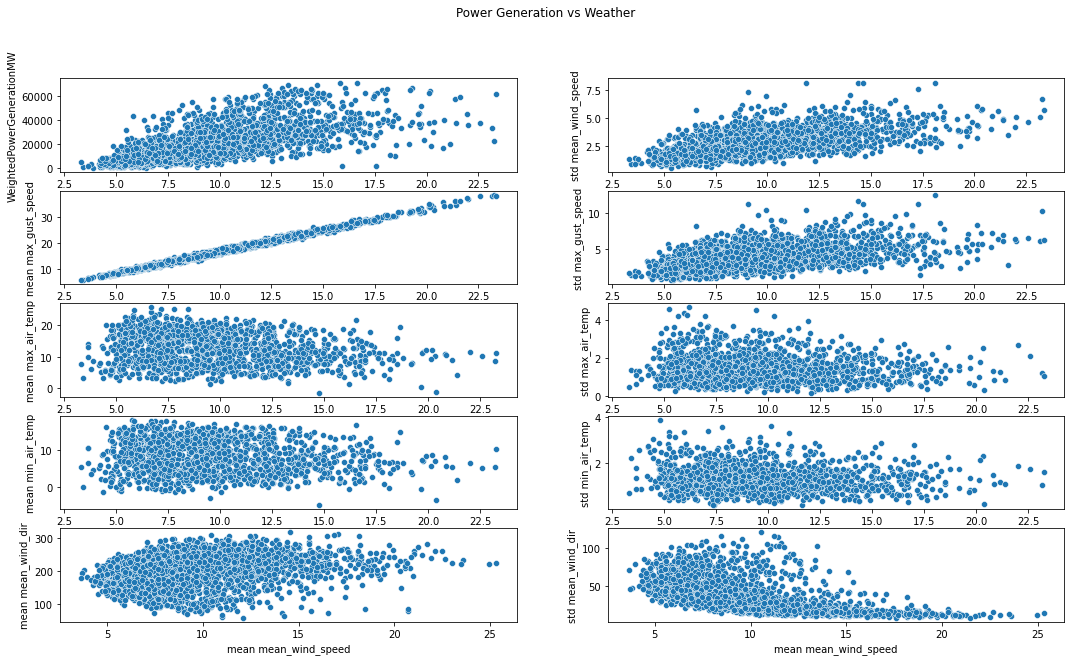

In [29]:
fig, axes = plt.subplots(5, 2, figsize=(18, 10))

fig.suptitle('Power Generation vs Weather')

sns.scatterplot(x="mean mean_wind_speed", y="WeightedPowerGenerationMW", data=comb_off, ax=axes[0, 0])
sns.scatterplot(x="mean mean_wind_speed", y="std mean_wind_speed", data=comb_off, ax=axes[0, 1])
sns.scatterplot(x="mean mean_wind_speed", y="mean max_gust_speed", data=comb_off, ax=axes[1, 0])
sns.scatterplot(x="mean mean_wind_speed", y="std max_gust_speed", data=comb_off, ax=axes[1, 1])
sns.scatterplot(x="mean mean_wind_speed", y="mean max_air_temp", data=comb_off, ax=axes[2, 0])
sns.scatterplot(x="mean mean_wind_speed", y="std max_air_temp", data=comb_off, ax=axes[2, 1])
sns.scatterplot(x="mean mean_wind_speed", y="mean min_air_temp", data=comb_off, ax=axes[3, 0])
sns.scatterplot(x="mean mean_wind_speed", y="std min_air_temp", data=comb_off, ax=axes[3, 1])
sns.scatterplot(x="mean mean_wind_speed", y="mean mean_wind_dir", data=comb_on, ax=axes[4, 0])
sns.scatterplot(x="mean mean_wind_speed", y="std mean_wind_dir", data=comb_on, ax=axes[4, 1])

plt.show()

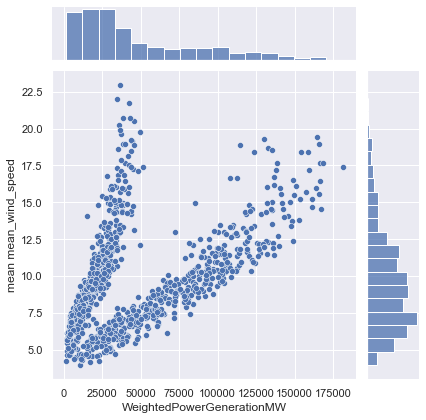

In [305]:
sns.jointplot(data=comb, x="WeightedPowerGenerationMW", y="mean mean_wind_speed")
plt.show()

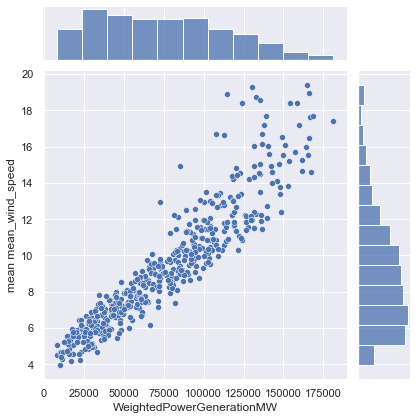

In [306]:
sns.jointplot(data=comb_on, x="WeightedPowerGenerationMW", y="mean mean_wind_speed")
plt.show()

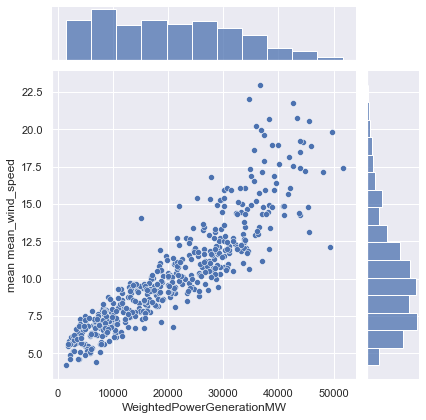

In [307]:
sns.jointplot(data=comb_off, x="WeightedPowerGenerationMW", y="mean mean_wind_speed")
plt.show()

#### Wind

In [285]:
wind_all["year"] = pd.DatetimeIndex(wind_all['ob_end_time']).year
wind_all["month"] = pd.DatetimeIndex(wind_all['ob_end_time']).month
wind_all["hour"] = pd.DatetimeIndex(wind_all['ob_end_time']).hour  

wind_all["season"] = np.select([wind_all["month"] <= 3, wind_all["month"] <= 9, 
                                wind_all["month"] <= 12], ["winter", "summer", "winter"] )

wind_all

observation_station ob_end_time  mean_wind_speed  mean_wind_dir  \
0             cairnwell  1997-01-01        18.625000     115.833333   
1             cairnwell  1997-01-02        21.416667      94.166667   
2             cairnwell  1997-01-03        20.041667      49.166667   
3             cairnwell  1997-01-04         9.416667      38.750000   
4             cairnwell  1997-01-05        16.750000      37.500000   
..                  ...         ...              ...            ...   
360              valley  2009-12-27        15.625000     268.750000   
361              valley  2009-12-28         4.208333      80.833333   
362              valley  2009-12-29        17.416667      62.916667   
363              valley  2009-12-30        23.166667      62.083333   
364              valley  2009-12-31        12.458333      54.166667   

     max_gust_dir  max_gust_speed  year  month  hour  season  
0      100.000000       26.125000  1997      1     0  winter  
1       88.333333       30.750000  1997      1     0  winter  
2       47.916667       29.250000  1997      1     0  winter  
3       44.583333       15.416667  1997      1     0  winter  
4       43.750000       23.458333  1997      1     0  winter  
..            ...             ...   ...    ...   ...     ...  
360    279.166667       24.166667  2009     12     0  winter  
361     76.250000        6.916667  2009     12     0  winter  
362     64.583333       26.583333  2009     12     0  winter  
363     62.916667       35.541667  2009     12     0  winter  
364     54.583333       19.916667  2009     12     0  winter  

[366537 rows x 10 columns]

In [211]:
# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

df

x  g
0    64.038123  A
1    66.147050  B
2    66.370011  C
3    68.791019  D
4    70.583534  E
..         ... ..
495  69.358022  F
496  72.212877  G
497  70.474247  H
498  73.251022  I
499  74.461828  J

[500 rows x 2 columns]

In [302]:
df = wind_all.copy()
df["year_period"] = wind_all["year"].astype(str)# + "_" + wind_all["season"].astype(str)
df = df[["mean_wind_speed", "year_period"]]# , "month"
#df["g"] = df["year"].astype(str) + "_" + df["month"].astype(str)
df = df.rename(columns={"mean_wind_speed":"x","year_period":"g"})
#df["g"] = df["g"].to_string()
#df = df[df["x"] <= 20]
#df = df[df["g"] >= 2015]
#df.groupby("g").describe()
df

x     g
0    18.625000  1997
1    21.416667  1997
2    20.041667  1997
3     9.416667  1997
4    16.750000  1997
..         ...   ...
360  15.625000  2009
361   4.208333  2009
362  17.416667  2009
363  23.166667  2009
364  12.458333  2009

[366537 rows x 2 columns]

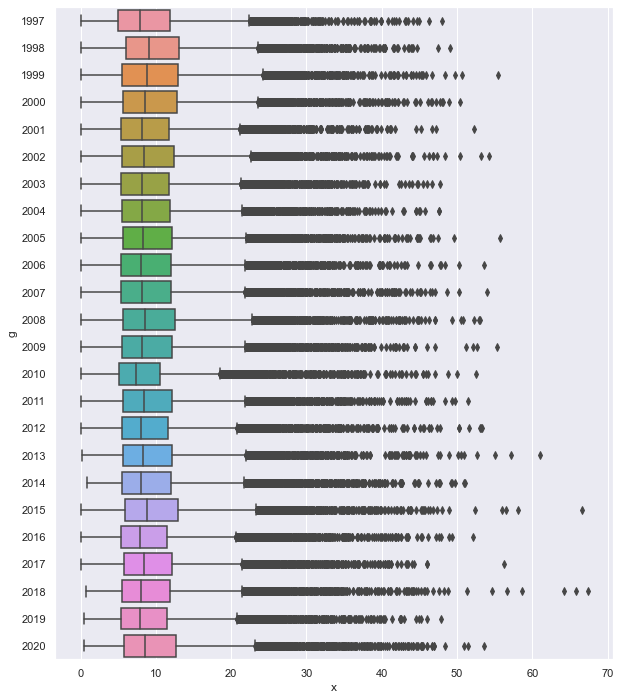

In [303]:
#fig, axes = plt.subplots(1, 2,figsize=(18, 10))

#fig.suptitle('Power Generation vs Weather')

sns.boxplot(x="x", y="g", data=df)
plt.rcParams['figure.figsize']=(10,12)
#sns.boxplot(y="mean mean_wind_speed", x="month", data=comb_on, ax=axes[1])
#sns.lineplot(x="WeightedPowerGenerationMW", y="ob_end_time", data=comb, ax=axes[0, 1])
plt.show()

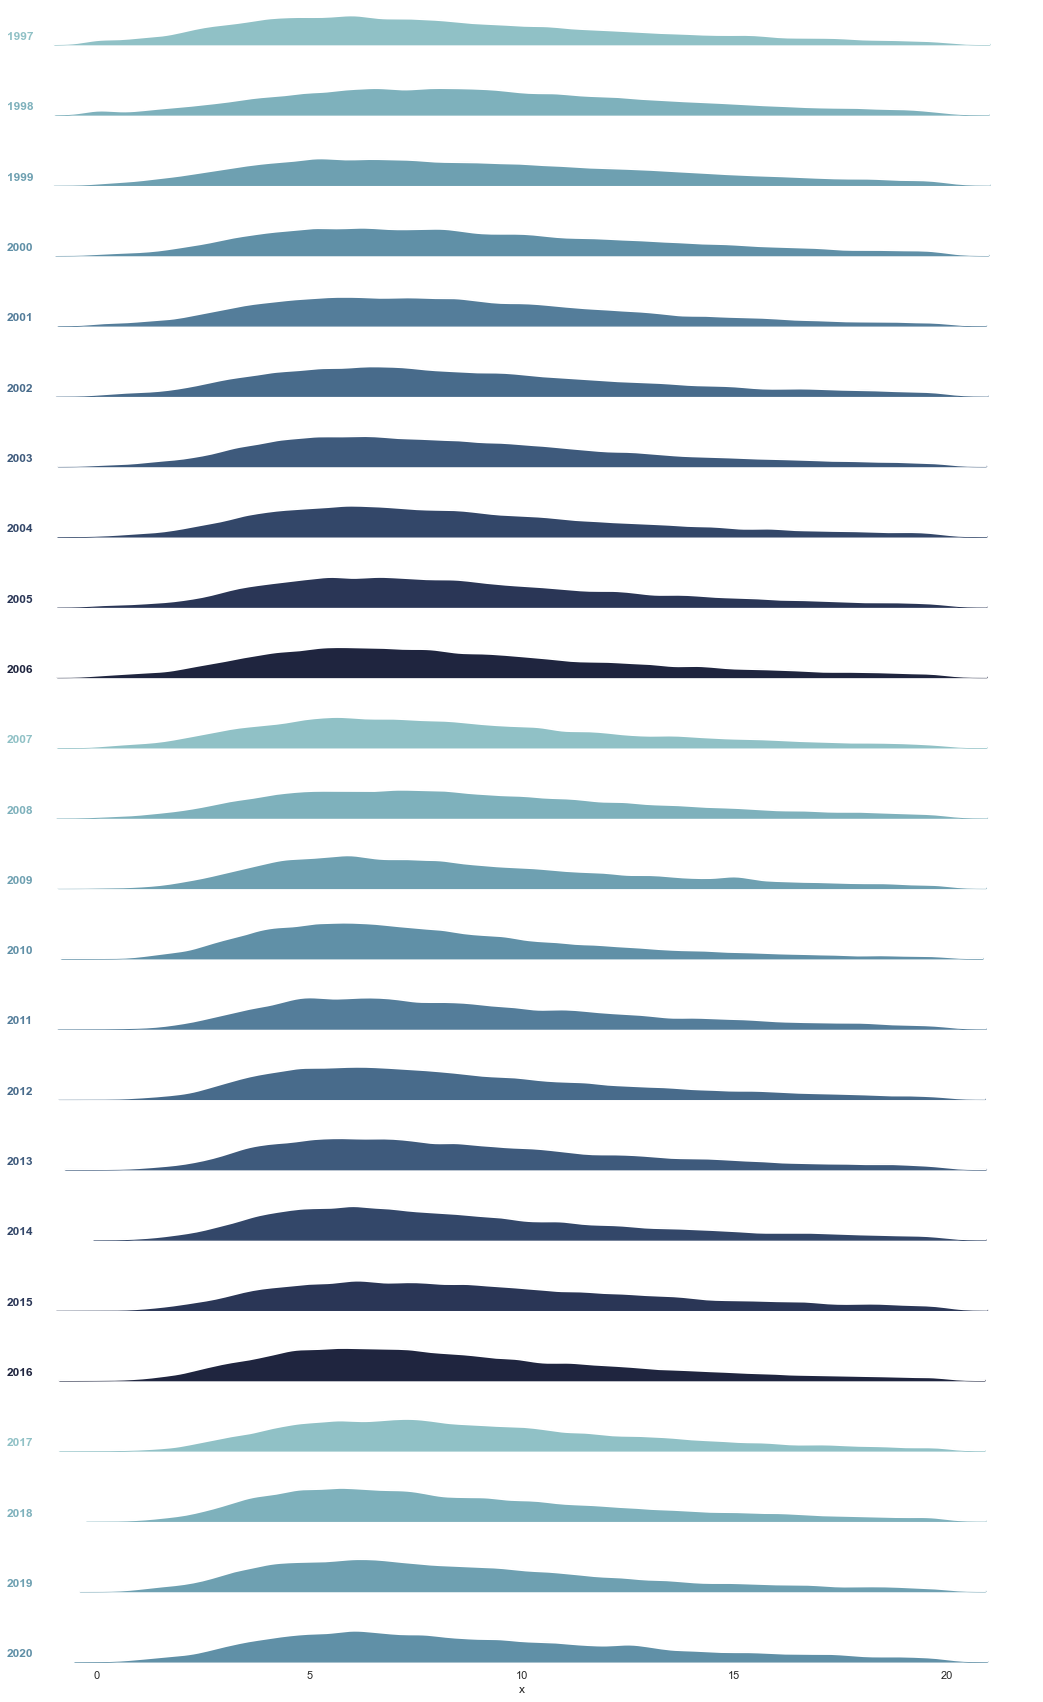

In [237]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
#g.map(plt.axhline, y=0, lw=2, clip_on=False)

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False, legend=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
#g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.show()

#### Extreme Wind Year Comparison

##### Visuals

In [34]:
extreme_year = comb[comb["extreme_wind"] == "yes"][["PowerGenerationMW", "mean mean_wind_speed"]]
non_extreme_year = comb[comb["extreme_wind"] == "no"][["PowerGenerationMW", "mean mean_wind_speed"]]

print("Extreme")
print(extreme_year.describe())
print("Not Extreme")
print(non_extreme_year.describe())

Extreme
       PowerGenerationMW  mean mean_wind_speed
count        2192.000000           2192.000000
mean       110642.443226             10.016493
std         74559.440785              3.755259
min           800.000000              3.625000
25%         48850.187750              7.043816
50%         95211.092500              9.318936
75%        157404.394000             12.352187
max        356306.566000             25.304630
Not Extreme
       PowerGenerationMW  mean mean_wind_speed
count        2184.000000           2184.000000
mean        99616.576587              9.548179
std         62441.318564              3.127318
min           356.578000              3.296296
25%         49496.552250              7.204301
50%         89613.102000              9.139388
75%        140655.581750             11.315986
max        331869.258000             23.592730


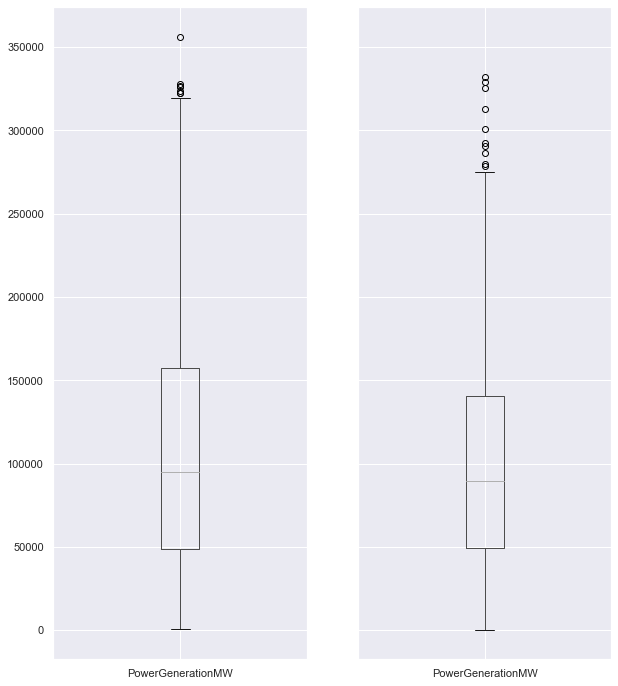

In [542]:
fig, axes = plt.subplots(ncols=2,sharey=True)
extreme_year.boxplot("PowerGenerationMW", ax=axes[0])
non_extreme_year.boxplot("PowerGenerationMW", ax=axes[1])
plt.show()

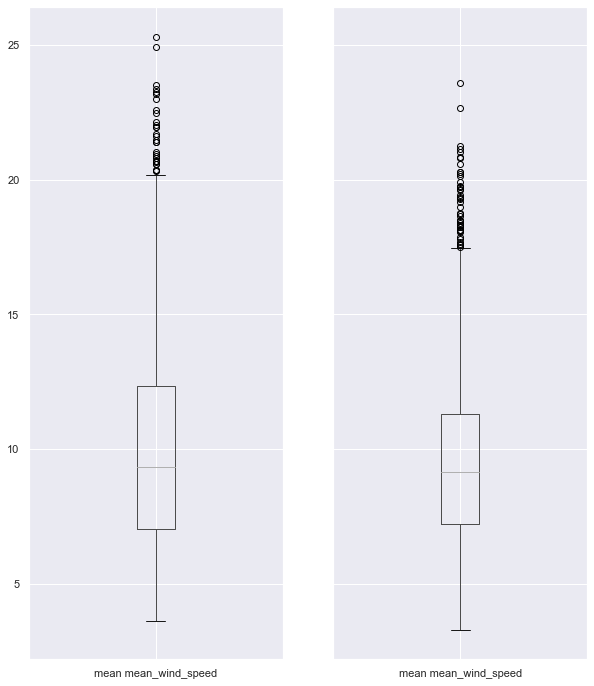

In [543]:
fig, axes = plt.subplots(ncols=2,sharey=True)
extreme_year.boxplot("mean mean_wind_speed", ax=axes[0])
non_extreme_year.boxplot("mean mean_wind_speed", ax=axes[1])
plt.show()

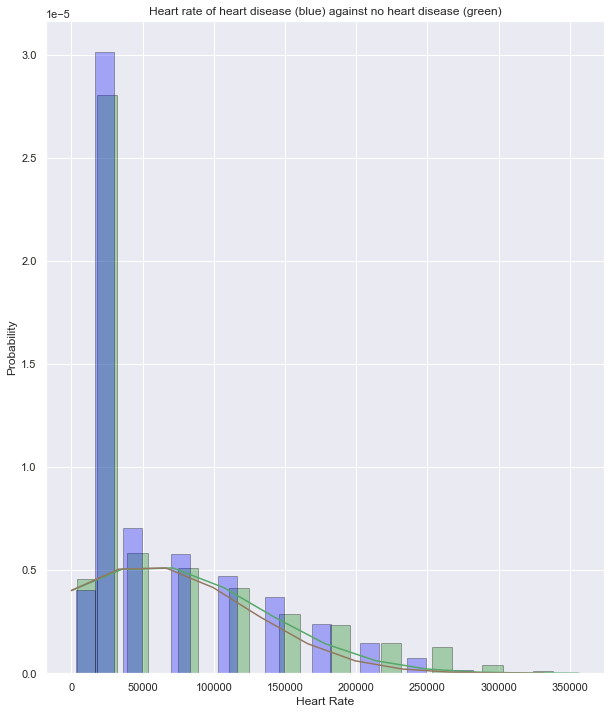

In [545]:
from scipy.stats import norm
# Create histogram from data
_, bins1, _ = plt.hist(extreme_year, 10 ,density=1, facecolor="green", 
                            edgecolor='black', alpha=0.3)

# Get mu and sigma for e_pop_num
mu1, sigma1 = norm.fit(extreme_year)

# Get a line of best fit for the data.
best_fit_line1 = norm.pdf(bins1, mu1, sigma1)
plt.plot(bins1, best_fit_line1)

# Create histogram from data
_, bins2, _ = plt.hist(non_extreme_year, 10 ,density=1, facecolor="blue", 
                            edgecolor='black', alpha=0.3)

# Get mu and sigma for e_pop_num
mu2, sigma2 = norm.fit(non_extreme_year)

# Get a line of best fit for the data.
best_fit_line2 = norm.pdf(bins2, mu2, sigma2)
plt.plot(bins2, best_fit_line1)

#plt.title(r'$\mathrm{Histogram\ has:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.title("Heart rate of heart disease (blue) against no heart disease (green)")
plt.xlabel('Heart Rate')
plt.ylabel('Probability')
plt.show()

In [547]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
import scipy as sp
sp.stats.ttest_ind(extreme_year, non_extreme_year)

Ttest_indResult(statistic=array([5.30231661, 4.48180304]), pvalue=array([1.19981896e-07, 7.59069990e-06]))

<AxesSubplot:xlabel='extreme_wind', ylabel='PowerGenerationMW'>

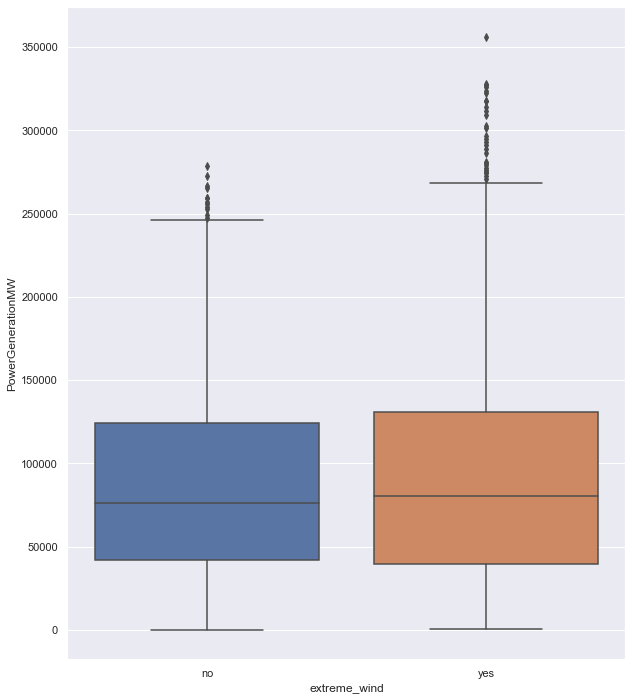

In [450]:
sns.boxplot(data=comb, x="extreme_wind", y="PowerGenerationMW")

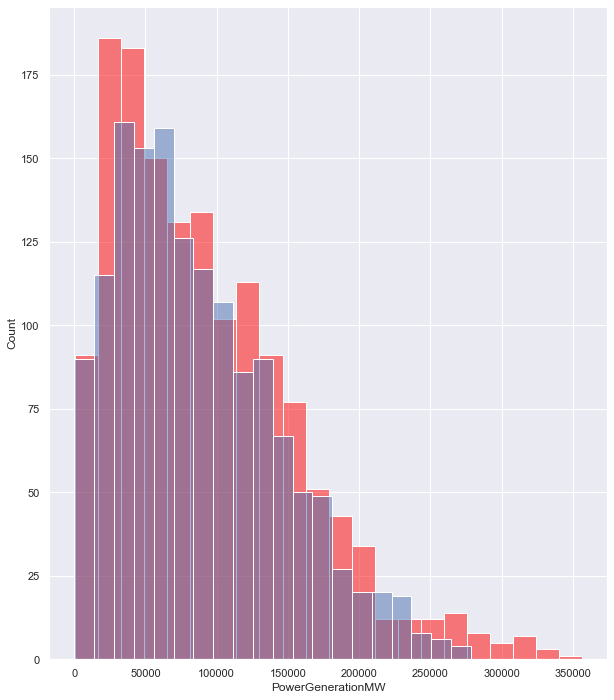

In [454]:
sns.histplot(data=extreme_year, x="PowerGenerationMW", alpha= 0.5, color="red")
sns.histplot(data=non_extreme_year, x="PowerGenerationMW", alpha= 0.5)
plt.show()

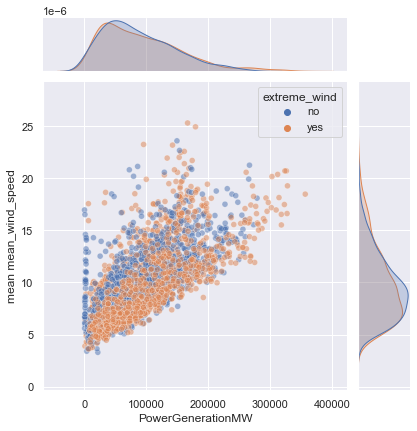

In [459]:
sns.jointplot(data=comb, x="PowerGenerationMW", y="mean mean_wind_speed", hue="extreme_wind", alpha = 0.5)
plt.show()

In [11]:
yr_no = {'year': [2015, 2016, 2017, 2018, 2019, 2020], 'year_no': [1, 1,2,2,3,3]}
yr_no_df = pd.DataFrame(data=yr_no)
ex_compare = comb.copy()
ex_compare = pd.merge(ex_compare, yr_no_df, on = "year")
ex_compare = ex_compare.pivot_table(index=["day", "month", "year_no", "Technology Type"], 
                                    values="PowerGenerationMW", columns="extreme_wind").reset_index()
ex_compare = ex_compare.dropna()
ex_compare.to_csv("ex_compare.csv")
ex_compare

extreme_wind  day  month  year_no Technology Type          no         yes
0               1      1        1   Wind Offshore   74999.837    6542.735
1               1      1        1    Wind Onshore  163032.573   34174.872
2               1      1        2   Wind Offshore  114086.635  152698.923
3               1      1        2    Wind Onshore  181029.604  193641.715
4               1      1        3   Wind Offshore  124926.366   98362.717
...           ...    ...      ...             ...         ...         ...
2189           31     12        1    Wind Onshore  180875.652  124375.357
2190           31     12        2   Wind Offshore  160899.130   90652.114
2191           31     12        2    Wind Onshore  235820.989  267407.018
2192           31     12        3   Wind Offshore   76179.857   80991.621
2193           31     12        3    Wind Onshore   97348.168  121907.117

[2182 rows x 6 columns]

In [28]:
extreme_year_pwr = ex_compare["yes"]
non_extreme_year_pwr = ex_compare["no"]
print(extreme_year_pwr.mean(), non_extreme_year_pwr.mean())

110765.15351351952 99650.76272571037


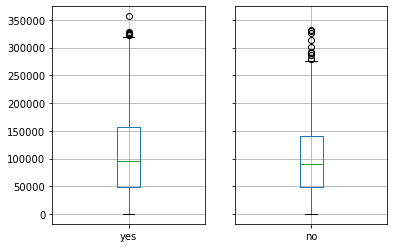

In [24]:
fig, axes = plt.subplots(ncols=2,sharey=True)
ex_compare.boxplot("yes", ax=axes[0])
`.boxplot("no", ax=axes[1])
plt.show()

In [27]:
ex_compare.describe()[["no","yes"]]

extreme_wind             no            yes
count           2182.000000    2182.000000
mean           99650.762726  110765.153514
std            62449.901743   74370.533574
min              356.578000     800.000000
25%            49513.151750   49095.040250
50%            89613.102000   95423.997000
75%           140780.013250  157412.990000
max           331869.258000  356306.566000

##### Regression Test

In [45]:
def simple_regression_kfold (df, independent, dependent):
    from sklearn.model_selection import KFold
    import scipy.stats as stats
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score

    kf = KFold(n_splits=5)
    foldCount = 0
    for train_idxs, test_idxs in kf.split(df):
        print("Run: ", foldCount)
        #print(len(cr),len(train_idxs),len(test_idxs))
        #put your code here
        dependentSubset = np.array(dependent.iloc[train_idxs]).reshape(-1, 1)
        independentSubset = np.array(independent.iloc[train_idxs]).reshape(-1, 1)
        dependentSubsetUnseen = np.array(dependent.iloc[test_idxs]).reshape(-1, 1)
        independentSubsetUnseen = np.array(independent.iloc[test_idxs]).reshape(-1, 1)

        # Create linear regression object
        regr = LinearRegression()

        # Train the model using the training sets
        regr.fit(independentSubset, dependentSubset)

        # Make predictions using the testing set
        y_pred = regr.predict(independentSubsetUnseen)

        # The coefficients
        print("Coefficients: %.2f" % regr.coef_)
        # The mean squared error
        print("Mean squared error: %.2f" % mean_squared_error(dependentSubsetUnseen, y_pred))
        # The coefficient of determination: 1 is perfect prediction
        print("Coefficient of determination: %.2f" % r2_score(dependentSubsetUnseen, y_pred))

        res = dependentSubsetUnseen - y_pred
    #     print("Residual Median: %.2f" % np.median(res))
    #     print("Residual Min: %.2f" % np.min(res))
    #     print("Residual Max: %.2f" % np.max(res))
    #     print("Residual 25th Quantile: %.2f" % np.quantile(res, 0.25))
    #     print("Residual 75th Quantile: %.2f" % np.quantile(res, 0.75))

        print("Residual: %.2f " % np.min(res) + "%.2f " % np.quantile(res, 0.25) +
              "%.2f " % np.median(res)  + "%.2f " % np.quantile(res, 0.75) +
            "%.2f " % np.max(res)) 
        
        #residual plot
        plt.hist(res, alpha = 0.5)
        plt.plot()
        
#         plt.scatter(independentSubsetUnseen, dependentSubsetUnseen, color="black")
#         plt.plot(independentSubsetUnseen, y_pred, color="blue", linewidth=3)
        
        foldCount += 1 
        #return(y_pred)

Run:  0
Coefficients: 16149.14
Mean squared error: 4550380592.76
Coefficient of determination: -1.16
Residual: -237632.22 -72401.13 -52728.15 -36351.64 30347.61 
Run:  1
Coefficients: 15653.87
Mean squared error: 3272860718.72
Coefficient of determination: 0.24
Residual: -229079.57 -59232.14 -32177.39 -10481.69 88332.60 
Run:  2
Coefficients: 13977.06
Mean squared error: 1284241688.20
Coefficient of determination: 0.69
Residual: -83721.46 -23963.12 -4508.52 25001.55 127821.22 
Run:  3
Coefficients: 12923.17
Mean squared error: 4123936865.59
Coefficient of determination: 0.36
Residual: -87300.13 10351.39 45165.57 83483.91 148675.47 
Run:  4
Coefficients: 14017.47
Mean squared error: 3568475424.79
Coefficient of determination: 0.35
Residual: -39287.01 7146.99 36253.04 69752.57 159808.78 


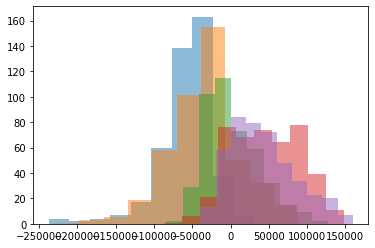

In [50]:
independent=extreme_year["mean mean_wind_speed"]; #X 
dependent = extreme_year["PowerGenerationMW"] #y

simple_regression_kfold(extreme_year, independent, dependent)

Run:  0
Coefficients: 16193.25
Mean squared error: 2940780088.08
Coefficient of determination: -0.71
Residual: -217217.29 -52170.02 -28796.00 -14626.52 27749.44 
Run:  1
Coefficients: 14475.47
Mean squared error: 1115599735.98
Coefficient of determination: 0.65
Residual: -114810.34 -28902.64 -7524.06 10948.69 78179.93 
Run:  2
Coefficients: 14068.54
Mean squared error: 1975125869.44
Coefficient of determination: 0.45
Residual: -167076.33 -40978.67 -11702.31 13441.33 82994.23 
Run:  3
Coefficients: 13681.34
Mean squared error: 2344050838.35
Coefficient of determination: 0.47
Residual: -75638.99 -2234.16 22916.08 55655.19 160510.05 
Run:  4
Coefficients: 13634.11
Mean squared error: 2705178316.91
Coefficient of determination: 0.34
Residual: -54600.62 6337.88 30582.23 60307.04 150278.96 


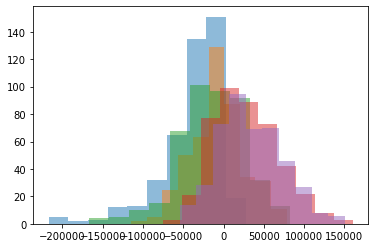

In [52]:
independent=non_extreme_year["mean mean_wind_speed"]; #X 
dependent = non_extreme_year["PowerGenerationMW"] #y

simple_regression_kfold(non_extreme_year, independent, dependent)

##### P Values

In [556]:
from sklearn.preprocessing import scale
ex_compare_st = scale(ex_compare[["no", "yes"]])
ex_compare_st

array([[-0.3948217 , -1.40171522],
       [ 1.01515514, -1.03008321],
       [ 0.23121223,  0.5639785 ],
       ...,
       [ 2.18097125,  2.10671839],
       [-0.3759219 , -0.40043221],
       [-0.03687952,  0.14985125]])

In [536]:
ex_compare.groupby("year_no").count()

extreme_wind  day  month  Technology Type   no  yes
year_no                                            
1             722    722              722  722  722
2             730    730              730  730  730
3             730    730              730  730  730

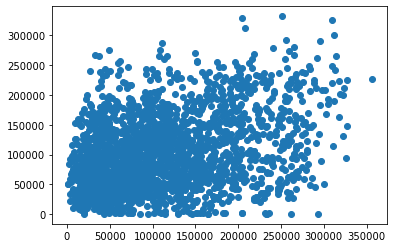

In [31]:
plt.scatter(extreme_year_pwr, non_extreme_year_pwr)
plt.show()

In [30]:
from scipy import stats

stats.spearmanr(extreme_year_pwr, non_extreme_year_pwr)

# rng = np.random.default_rng()

# x2n = rng.standard_normal((100, 2))

# y2n = rng.standard_normal((100, 2))

# #stats.spearmanr(x2n)
# x2n

SpearmanrResult(correlation=0.31601748580604355, pvalue=8.422351936910922e-52)

In [560]:
print(stats.spearmanr(non_extreme_year["PowerGenerationMW"], non_extreme_year["mean mean_wind_speed"]))
print(stats.spearmanr(extreme_year["PowerGenerationMW"], extreme_year["mean mean_wind_speed"]))

SpearmanrResult(correlation=0.7530050445549102, pvalue=0.0)
SpearmanrResult(correlation=0.7727230008519542, pvalue=0.0)


In [550]:
sp.stats.ttest_ind(ex_compare["yes"], ex_compare["no"])

Ttest_indResult(statistic=5.346073618683052, pvalue=9.44752866401184e-08)

In [563]:
#https://machinelearningmastery.com/effect-size-measures-in-python/
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s
 
# calculate cohen's d
#d = cohend(bps_dis, bps_nodis)
d = cohend(ex_compare["yes"], ex_compare["no"])
print('Cohens d extreme Wind: %.3f' % d)
#print('Cohens d chol: %.3f' % d)


Cohens d extreme Wind: 0.162


##### QQ Plot

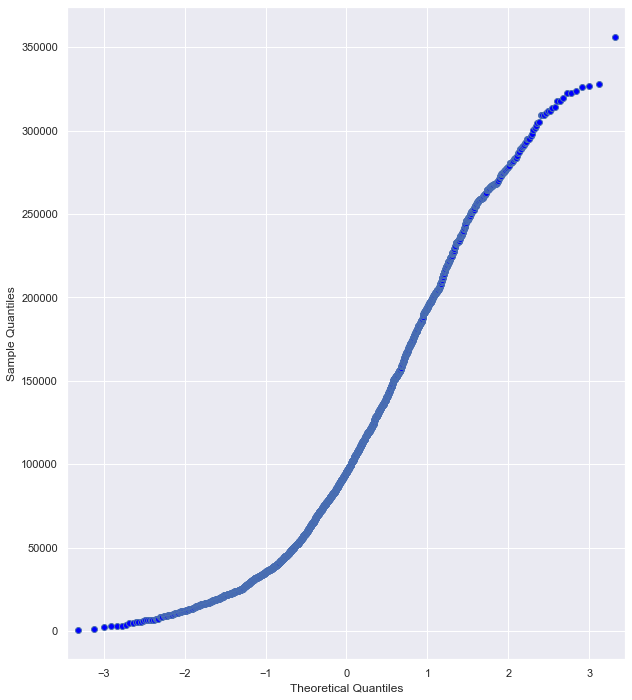

In [569]:
import statsmodels.api as sm

sm.qqplot(ex_compare["yes"])#, line='45')
plt.show()

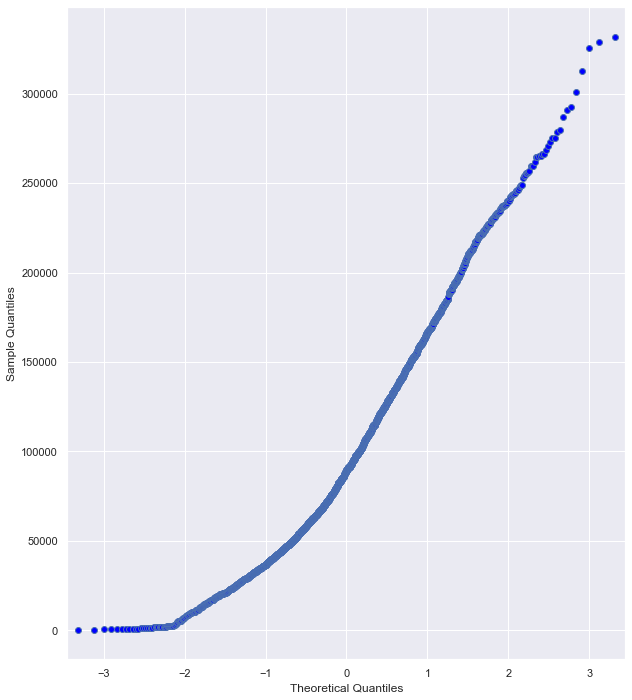

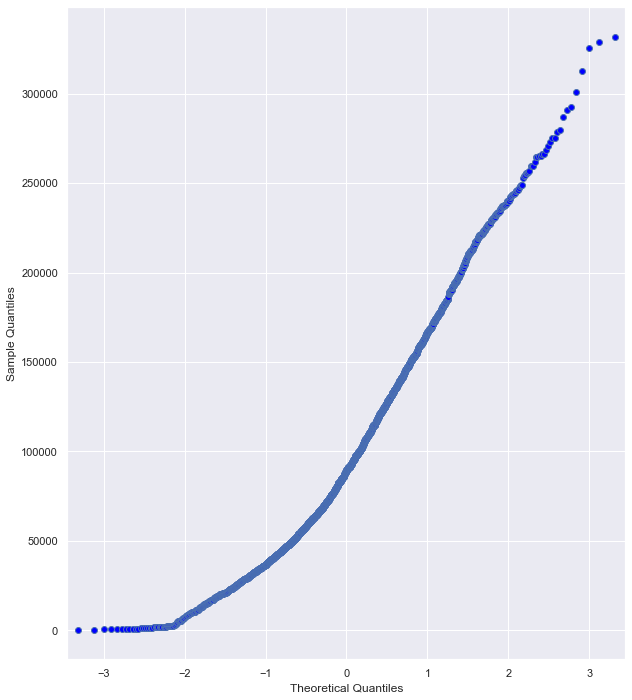

In [571]:
sm.qqplot(ex_compare["no"])#, line='45')

#### Feature Selection

In [75]:
comb.columns

Index(['Unnamed: 0', 'ob_end_time', 'Technology Type', 'PowerGenerationMW',
       'sum max_gust_dir', 'sum max_gust_speed', 'sum mean_wind_dir',
       'sum mean_wind_speed', 'mean max_gust_dir', 'mean max_gust_speed',
       'mean mean_wind_dir', 'mean mean_wind_speed', 'std max_gust_dir',
       'std max_gust_speed', 'std mean_wind_dir', 'std mean_wind_speed',
       'var max_gust_dir', 'var max_gust_speed', 'var mean_wind_dir',
       'var mean_wind_speed', 'sum Installed Capacity (MWelec)',
       'sum No. of Turbines', 'sum Turbine Capacity (MW)', 'sum blade_width',
       'mean max_air_temp', 'mean min_air_temp', 'std max_air_temp',
       'std min_air_temp', 'avg_turbine_capacity', 'WeightedPowerGenerationMW',
       'year', 'month', 'hour', 'day', 'extreme_wind'],
      dtype='object')

In [103]:
from sklearn.preprocessing import scale
# comb_pca = comb.drop(columns=["Unnamed: 0", "ob_end_time", "PowerGenerationMW", "avg_turbine_capacity", 
#                               "WeightedPowerGenerationMW", "year", "month", "hour", "day", 
#                               "sum Installed Capacity (MWelec)", "sum Turbine Capacity (MW)", 
#                               "sum No. of Turbines", "sum blade_width", "sum max_gust_dir", 
#                               "sum max_gust_speed"])

comb_pca = comb[["std mean_wind_speed", "std max_air_temp", "std min_air_temp", "sum No. of Turbines"]]

comb_pca = pd.get_dummies(comb_pca)

comb_corr = comb[["PowerGenerationMW", "std mean_wind_speed", "std max_air_temp", "std min_air_temp"]]

# comb_corr = comb.drop(columns=["Unnamed: 0", "ob_end_time", "avg_turbine_capacity", 
#                               "WeightedPowerGenerationMW", "year", "month", "hour", "day", 
#                               "sum Installed Capacity (MWelec)", "sum Turbine Capacity (MW)", 
#                               "sum No. of Turbines", "sum blade_width", "sum max_gust_dir", 
#                               "sum max_gust_speed", "Technology Type", "extreme_wind"])


comb_pca = comb_pca.dropna()
comb_pca_st = scale(comb_pca)
comb_pca_st

array([[-0.53572352, -0.73740117,  0.28461393, -0.99996971],
       [ 1.94120409, -0.93812514, -0.31077443,  0.99680337],
       [ 0.68805388,  0.07001717,  0.21464894, -0.99996971],
       ...,
       [ 0.26523754, -0.90093381, -0.23657946,  1.00583855],
       [ 1.34485135, -1.23800733, -0.03365598, -0.99996971],
       [ 2.30865812, -0.95291177, -1.16732441,  1.00583855]])

In [93]:
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = comb_pca
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["PowerGenerationMW"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

     PowerGenerationMW       VIF
0  std mean_wind_speed  6.176122
1     std max_air_temp  7.094777
2     std min_air_temp  9.199028
3  sum No. of Turbines  5.808216


In [94]:
from sklearn.decomposition import PCA
pca_comb = PCA(n_components=2)
pca_comb.fit(comb_pca_st)
print(pca_comb.explained_variance_)
print(pca_comb.explained_variance_ratio_)

[1.86648607 1.17117887]
[0.46646139 0.29269424]


In [95]:
pca_comb_proj = PCA(2)  # project from 64 to 2 dimensions
Xproj_comb = pca_comb.fit_transform(comb_pca_st)
print(comb_pca_st.shape)
print(Xproj_comb.shape)

(2914, 4)
(2914, 2)


In [96]:
pca_comb_proj_df = pd.DataFrame(pca_comb.components_)
pca_comb_proj_df.columns = comb_pca.columns
pca_comb_proj_df

std mean_wind_speed  std max_air_temp  std min_air_temp  \
0             0.402332          0.474728          0.538431   
1            -0.666629          0.545280          0.377003   

   sum No. of Turbines  
0             0.568203  
1            -0.340800

In [97]:
pca_comb_proj_df_t = pca_comb_proj_df.transpose()
pca_comb_proj_df_t.columns = ["feature1", "feature2"]
pca_comb_proj_df_t = pca_comb_proj_df_t.abs()
pca_comb_proj_df_t = pca_comb_proj_df_t.reset_index()
pca_comb_proj_df_t.sort_values(by=['feature1'], ascending=False)

index  feature1  feature2
3  sum No. of Turbines  0.568203  0.340800
2     std min_air_temp  0.538431  0.377003
1     std max_air_temp  0.474728  0.545280
0  std mean_wind_speed  0.402332  0.666629

<AxesSubplot:>

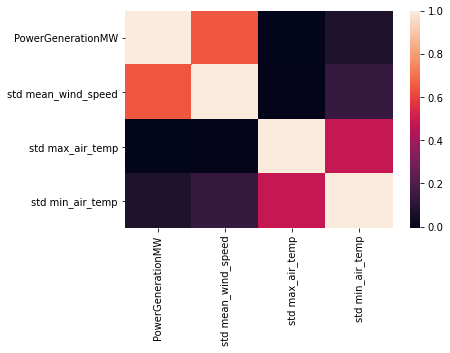

In [104]:
# calculate the correlation matrix
corr = comb_corr.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

#### Locations Wind and Farms

In [ ]:
#blend and join farm and wind to able able to visualise on one map

loc_farm = farm.pivot_table(values = ["Installed Capacity (MWelec)", "Installed Capacity (MWelec) Norm"], 
                            index = ["Site Name", "lat", "long", "X", "Y"], 
                            aggfunc = "mean").reset_index()
#TODO, add the raw file into another list 
#this is because I need to show the variability of the data
loc_farm = loc_farm.rename(columns={"Site Name": "name", "Installed Capacity (MWelec)": "value",
                                    "Installed Capacity (MWelec) Norm": "value_norm"})
loc_farm["data_source"] = "farm" 

loc_wind = wind_mean.pivot_table(values = wind_values, 
                            index = ["observation_station", "lat", "long", "X", "Y"], 
                            aggfunc = "mean").reset_index()

loc_wind = loc_wind.rename(columns={"observation_station": "name", "mean_wind_speed": "value",
                                    "mean_wind_speed_norm": "value_norm"})

loc_wind["data_source"] = "station" 

loc_all = loc_wind.append(loc_farm)

loc_all.to_csv(root_local + "loc_all.csv")

### Granger

#### Transforming

https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2

In [96]:
comb = pd.read_csv(root_local + "combined.csv")
comb.head(2)

pwr = comb[["ob_end_time","PowerGenerationMW", "mean mean_wind_speed", "mean min_air_temp"]]
pwr.columns = ["ob_end_time", "pwr", "wnd", "temp"] 
pwr = pwr.set_index('ob_end_time').rename_axis('company', axis=1)
#wnd_pwr = wnd_pwr.dropna()

pwr_ex = wnd_pwr[wnd_pwr.index < "2018-01-01"]
pwr_non_ex = wnd_pwr[wnd_pwr.index >= "2018-01-01"]

# print(wnd_pwr_ex.describe())
# print(wnd_pwr_non_ex.describe())
pwr

company             pwr        wnd      temp
ob_end_time                                 
2015-01-01     6542.735  15.929825  6.693750
2015-01-01    34174.872  18.648189  7.311491
2015-01-02     6411.548  17.561404  5.116667
2015-01-02    32388.259  17.642733  3.313043
2015-01-03     2569.678   8.901316  2.514583
...                 ...        ...       ...
2020-12-29   108245.090   7.882316  0.490673
2020-12-30   102011.768   5.541667 -0.016667
2020-12-30    76006.310   5.537577 -0.839144
2020-12-31    80991.621   7.151316 -1.539583
2020-12-31   121907.117   6.542178 -1.125382

[4380 rows x 3 columns]

In [85]:
import plotly.express as px

fig = px.line(pwr, facet_col="company", facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

In [98]:
n_obs = 200
ex_train, ex_test = pwr_ex[0:-n_obs], pwr_ex[-n_obs:]
non_ex_train, non_ex_test = pwr_non_ex[0:-n_obs], pwr_non_ex[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('ADF Test: Power time series 2015-17')
adf_test(non_ex_train['pwr'])
print('ADF Test: Wind time series 2015-17')
adf_test(non_ex_train['wnd'])
print('ADF Test: Temp time series 2015-17')
adf_test(non_ex_train['temp'])

print('ADF Test: Power time series 2018-20')
adf_test(ex_train['pwr'])
print('ADF Test: Wind time series 2018-20')
adf_test(ex_train['wnd'])
print('ADF Test: Temp time series 2018-20')
adf_test(ex_train['temp'])

ADF Test: Power time series 2015-17
ADF Statistics: -6.575787
p-value: 0.000000
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Wind time series 2015-17
ADF Statistics: -6.372829
p-value: 0.000000
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Temp time series 2015-17
ADF Statistics: -2.287311
p-value: 0.176093
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Power time series 2018-20
ADF Statistics: -4.341364
p-value: 0.000376
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Wind time series 2018-20
ADF Statistics: -5.570844
p-value: 0.000001
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Temp time series 2018-20
ADF Statistics: -2.248700
p-value: 0.189047
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [88]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

In [99]:
print('KPSS Test: Power time series 2015-17')
kpss_test(non_ex_train['pwr'])
print('KPSS Test: Wind time series 2015-17')
kpss_test(non_ex_train['wnd'])
print('KPSS Test: Temp time series 2015-17')
adf_test(non_ex_train['temp'])

print('KPSS Test: Power time series 2018-20')
kpss_test(ex_train['pwr'])
print('KPSS Test: Wind time series 2018-20')
kpss_test(ex_train['wnd'])
print('KPSS Test: Temp time series 2018-20')
adf_test(ex_train['temp'])

KPSS Test: Power time series 2015-17
KPSS Statistic: 0.6665837671448639
p-value: 0.01658329389592146
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Wind time series 2015-17
KPSS Statistic: 0.15812283813623576
p-value: 0.1
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Temp time series 2015-17
ADF Statistics: -2.248700
p-value: 0.189047
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
KPSS Test: Power time series 2018-20
KPSS Statistic: 0.5830027555211114
p-value: 0.024181567679898965
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Wind time series 2018-20
KPSS Statistic: 0.5349186163173466
p-value: 0.03380211344203905
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Temp time series 2018-20
ADF Statistics: -2.287311
p-value: 0.176093
Critical values:
	1%: -3.434
	5%: -2.863
	10%:

C:\Users\lawrencer\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

C:\Users\lawrencer\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\lawrencer\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the

In [101]:
ex_train_transformed = ex_train.diff().dropna()
non_ex_train_transformed = non_ex_train.diff().dropna()

fig = px.line(ex_train_transformed, facet_col="company", facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

In [102]:
print('ADF Test: Power time series 2015-17')
adf_test(non_ex_train_transformed['pwr'])
print('ADF Test: Wind time series 2015-17')
adf_test(non_ex_train_transformed['wnd'])
print('ADF Test: Temp time series 2015-17')
adf_test(non_ex_train_transformed['temp'])

print('ADF Test: Power time series 2018-21')
adf_test(ex_train_transformed['pwr'])
print('ADF Test: Wind time series 2015-17')
adf_test(ex_train_transformed['wnd'])
print('ADF Test: Temp time series 2015-17')
adf_test(ex_train_transformed['temp'])

ADF Test: Power time series 2015-17
ADF Statistics: -15.279546
p-value: 0.000000
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Wind time series 2015-17
ADF Statistics: -14.717809
p-value: 0.000000
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Temp time series 2015-17
ADF Statistics: -12.011936
p-value: 0.000000
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Power time series 2018-21
ADF Statistics: -13.874122
p-value: 0.000000
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Wind time series 2015-17
ADF Statistics: -14.065455
p-value: 0.000000
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Test: Temp time series 2015-17
ADF Statistics: -12.634946
p-value: 0.000000
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [103]:
print('ADF Test: Power time series 2015-17')
kpss_test(non_ex_train_transformed['pwr'])
print('ADF Test: Wind time series 2015-17')
kpss_test(non_ex_train_transformed['wnd'])
print('ADF Test: Temp time series 2015-17')
kpss_test(non_ex_train_transformed['temp'])

print('ADF Test: Power time series 2018-21')
kpss_test(ex_train_transformed['pwr'])
print('ADF Test: Wind time series 2015-17')
kpss_test(ex_train_transformed['wnd'])
print('ADF Test: Temp time series 2015-17')
kpss_test(ex_train_transformed['temp'])

ADF Test: Power time series 2015-17
KPSS Statistic: 0.012339291431122442
p-value: 0.1
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
ADF Test: Wind time series 2015-17
KPSS Statistic: 0.011586608125696549
p-value: 0.1
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
ADF Test: Temp time series 2015-17
KPSS Statistic: 0.026361710262927746
p-value: 0.1
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
ADF Test: Power time series 2018-21
KPSS Statistic: 0.009528626458988707
p-value: 0.1
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
ADF Test: Wind time series 2015-17
KPSS Statistic: 0.014527149680752586
p-value: 0.1
num lags: 26
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
ADF Test: Temp time series 2015-17
KPSS Statistic: 0.0233800217189843
p-value: 0.1
num lags: 26
Critial Values:
   10% : 0.347
   5% 

C:\Users\lawrencer\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

C:\Users\lawrencer\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\lawrencer\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\lawrencer\Anaconda3\lib\site-packages\statsmodels

In [106]:
ex_train_transformed

company            pwr       wnd      temp
ob_end_time                               
2015-01-01   27632.137  2.718365  0.617741
2015-01-02  -27763.324 -1.086786 -2.194824
2015-01-02   25976.711  0.081330 -1.803623
2015-01-03  -29818.581 -8.741417 -0.798460
2015-01-03   11641.099  1.058630 -0.860236
...                ...       ...       ...
2017-09-20   55965.781  1.235472 -0.237658
2017-09-21  -26234.178 -0.055648  1.441825
2017-09-21  -17922.480 -1.217512 -2.639926
2017-09-22  -36105.940  0.412687  0.044093
2017-09-22   98765.215  0.950886 -1.432645

[1989 rows x 3 columns]

In [105]:
non_ex_train_transformed

company             pwr       wnd      temp
ob_end_time                                
2018-01-01    40942.792 -0.672752 -1.602791
2018-01-02   -49208.889 -0.680318  0.215291
2018-01-02    38600.765  0.293286 -0.462844
2018-01-03   -10760.470  6.485222  3.731594
2018-01-03    64678.392 -1.861756 -1.879148
...                 ...       ...       ...
2020-09-20   -89500.973 -0.620853 -2.712557
2020-09-21   -24061.230 -0.879147  1.150057
2020-09-21    56979.084  0.723050 -1.050669
2020-09-22     5336.596  3.188234  2.902752
2020-09-22   107659.791  1.411994 -1.189602

[1989 rows x 3 columns]

#### Modelling

In [108]:
from statsmodels.tsa.api import VAR

ex_model = VAR(ex_train_transformed)
for i in [1,5,10,15]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  22.635788966790205
BIC :  22.654366785184912
FPE :  6770149244.988623
HQIC:  22.642367862880302 

Lag Order = 5
AIC :  22.18942253028209
BIC :  22.26379520299828
FPE :  4332552301.736395
HQIC:  22.2157611704372 

Lag Order = 10
AIC :  22.090595986756195
BIC :  22.2348420390944
FPE :  3924861383.273331
HQIC:  22.14168305546198 

Lag Order = 15
AIC :  22.03796782631802
BIC :  22.25223194357138
FPE :  3723651935.7603946
HQIC:  22.113857662508487 



C:\Users\lawrencer\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [109]:
from statsmodels.tsa.api import VAR

non_ex_model = VAR(non_ex_train_transformed)
for i in [1,5,10,15]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  22.635788966790205
BIC :  22.654366785184912
FPE :  6770149244.988623
HQIC:  22.642367862880302 

Lag Order = 5
AIC :  22.18942253028209
BIC :  22.26379520299828
FPE :  4332552301.736395
HQIC:  22.2157611704372 

Lag Order = 10
AIC :  22.090595986756195
BIC :  22.2348420390944
FPE :  3924861383.273331
HQIC:  22.14168305546198 

Lag Order = 15
AIC :  22.03796782631802
BIC :  22.25223194357138
FPE :  3723651935.7603946
HQIC:  22.113857662508487 



C:\Users\lawrencer\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [110]:
results = ex_model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 27, Nov, 2021
Time:                     13:18:41
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    21.9685
Nobs:                     1974.00    HQIC:                   21.7214
Log likelihood:          -29562.3    FPE:                2.35041e+09
AIC:                      21.5778    Det(Omega_mle):     2.19346e+09
--------------------------------------------------------------------
Results for equation pwr
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           35.092979       642.960402            0.055           0.956
L1.pwr          -0.968156         0.031114          -31.117           0.000
L1.wnd       11047.088598       442.622601           24.958           0.000
L1.tem

In [111]:
results = non_ex_model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 27, Nov, 2021
Time:                     13:18:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    22.6343
Nobs:                     1974.00    HQIC:                   22.3871
Log likelihood:          -30219.4    FPE:                4.57395e+09
AIC:                      22.2436    Det(Omega_mle):     4.26854e+09
--------------------------------------------------------------------
Results for equation pwr
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           19.438846       962.437188            0.020           0.984
L1.pwr          -1.031729         0.034548          -29.864           0.000
L1.wnd       16209.868899       695.067238           23.321           0.000
L1.tem

In [110]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(wnd_pwr.columns, out):
    print(col, ':', round(val, 2))

pwr : 2.0
wnd : 1.99
temp : 2.0


In [112]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [113]:
grangers_causation_matrix(ex_train_transformed, variables = ex_train_transformed.columns)

pwr_x  wnd_x  temp_x
pwr_y     1.0    0.0  0.0000
wnd_y     0.0    1.0  0.0002
temp_y    0.0    0.0  1.0000

In [114]:
grangers_causation_matrix(non_ex_train_transformed, variables = non_ex_train_transformed.columns)

pwr_x  wnd_x  temp_x
pwr_y     1.0    0.0     0.0
wnd_y     0.0    1.0     0.0
temp_y    0.0    0.0     1.0

In [93]:
lag_order = results.k_ar

df_input = df_train_transformed.values[-lag_order:]
df_forecast = results.forecast(y=df_input, steps=n_obs)
df_forecast = (pd.DataFrame(df_forecast, index=df_test.index, columns=df_test.columns + '_pred'))

def invert_transformation(df, pred):
    forecast = df_forecast.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df_train, df_forecast)

combined = pd.concat([output['wnd_pred'], df_test['wnd'], output['pwr_pred'], df_test['pwr']], axis=1)

In [94]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


rmse = mean_squared_error(combined['wnd_pred'], combined['wnd'], squared=False)
mae = mean_absolute_error(combined['wnd_pred'], combined['wnd'])

print('Forecast accuracy of Wind')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

Forecast accuracy of Wind
RMSE:  3.79
MAE:  3.05


In [95]:
rmse = mean_squared_error(combined['pwr_pred'], combined['pwr'], squared=False)
mae = mean_absolute_error(combined['pwr_pred'], combined['pwr'])

print('Forecast accuracy of Power')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

Forecast accuracy of Power
RMSE:  82000.33
MAE:  70000.34


### Archive

In [ ]:
        #normalise the values to 0 1
#         mean_wind_speed = w["mean_wind_speed"]
#         if w.shape[0] != 0:
#             w["mean_wind_speed_norm"] = (mean_wind_speed-min(mean_wind_speed))
#/(max(mean_wind_speed)-min(mean_wind_speed))
#         else:
#             w["mean_wind_speed_norm"] = np.nan        
        
        #wind_mean = wind_mean.append(wind_piv)
        
        #         w["year"] = pd.DatetimeIndex(w['ob_end_time']).year
#         w["month"] = pd.DatetimeIndex(w['ob_end_time']).month
#         w["hour"] = pd.DatetimeIndex(w['ob_end_time']).hour  
        
        #w['mean_wind_speed'] = w.mean_wind_speed.ffill().add(w.mean_wind_speed.bfill()).div(2)
        #w['mean_wind_speed'] = w.mean_wind_speed.ffill().add(w.mean_wind_speed.bfill()).div(2)
        #w['max_gust_speed'] = w.max_gust_speed.ffill().add(w.mean_wind_speed.bfill()).div(2)
        #w = w.ffill().add(w.bfill()).div(2) 
                  #fix na values by taking an average of the value before and the value after
            #this is because wind probably went up and down smoothly 
            #in the hours that the station wasn't working  
        print(wind_all.isna().sum()) # check na's
    wind_all = wind_all.ffill().add(wind_all.bfill()).div(2) 

   gen = gen_all[["Business Type", "Power System Resource  Type", 
               "Settlement Date", "Quantity ", "Settlement Period"]]
gen.columns = gen.columns.str.replace(' ', '')

gen.to_csv(root_local + "gen.csv")
gen 
#%%
#This is used to speed up the process so its not always pulling from the ftp


#wind_mean.to_csv(root_local + "wind.csv")
    #wind_mean.to_csv(root_local + "wind_mean.csv")
    
#wind_mean = pd.merge(wind_mean, wind_coord, on = 'observation_station')
#farm_id = farm[["Ref ID", "Site Name","lat", "long", "X", "Y"]].copy()

                                    #print(info)

                                    #adds on any extra info required into the dataset
                                    obs_station = info.loc[info["Conventions"] == "observation_station"].iloc[0,2] 
    #                                 obs['observation_station'] = info.loc[info["Conventions"] == "observation_station"].iloc[0,2]
    #                                 obs['historic_county_name'] = info.loc[info["Conventions"] == "historic_county_name"].iloc[0,2]
    #                                 obs['lat'] = info.loc[info["Conventions"] == "location"].iloc[0,2]
    #                                 obs['long'] = info.loc[info["Conventions"] == "location"].iloc[0,3]
                                    #print(obs.head())
                                    #print(obs.shape)
            
            #farm = pd.merge(farm_id, wind[], right_on='observation_station',left_on = 'closest_dst_id')
            #extra set up for loading the data
temp_values =  ["max_air_temp","min_air_temp"]

temp_index = ["observation_station", "historic_county_name","lat","long"]
temp_extra = ["year", "month", "hour"]
temp_mean = pd.DataFrame(columns = temp_index + temp_extra + temp_values)

temp_all_cols =  temp_index + ["ob_end_time"] + temp_values
temp_all = pd.DataFrame(columns = temp_all_cols)

t = temp_list[1]
t = t.copy() # copy from list
t = t[t["id_type"] == "DCNN"] #filter for wind data
t = t[temp_all_cols] #reduce columns
#t = t.astype({'max_air_temp': 'float','min_air_temp': 'float', 'ob_end_time':'datetime64'}).dtypes
#t.to_csv(root_local + "temp_test.csv")
t['ob_end_time'] = pd.to_datetime(t['ob_end_time'], format = '%Y-%m-%d %H:%M:%S') 
t.info()

if (load_ftp):   
    index = 0
    for t in temp_list:
        index += 1
        t = t.copy() # copy from list
        t = t[t["id_type"] == "DCNN"] #filter for wind data
        t = t[temp_all_cols] #reduce columns
        #t = t.astype({'max_air_temp': 'float','min_air_temp': 'float'}).dtypes
        #print(t.info())
        #t = t.ffill().add(t.bfill()).div(2) 
        # I am taking a lot of wind data to create a trend 
            #I don't need to make data up so can safly remove
        #t = t.dropna() 
        #change in temperature with a fill forward 
        #resample data to reduce the size
        if t.shape[0] != 0:
            t['ob_end_time'] = pd.to_datetime(t['ob_end_time'], format = '%Y-%m-%d %H:%M:%S')       
            t = t.set_index("ob_end_time")
            #TODO:resample into other types of calculation
            t_rsm = t.groupby(["observation_station", "historic_county_name",
                            "lat","long"]).resample('D').mean().reset_index()
            temp_all = temp_all.append(t_rsm)

    temp_all.to_csv(root_local + "temp_all.csv")
    
temp_all.info()

farm_raw = pd.read_csv(root_local + "renewable-energy-planning-database-q2-june-2021.csv")

farm = farm_raw[farm_raw["Technology Type"].isin(["Wind Onshore", "Wind Offshore"])]
farm = farm[farm["Development Status"] == "Operational"]
farm = farm.rename(columns={"X-coordinate": "X", "Y-coordinate": "Y"})

cols = ["Ref ID","Operator (or Applicant)","Site Name","Technology Type","Installed Capacity (MWelec)",
"Turbine Capacity (MW)","No. of Turbines","Height of Turbines (m)","Address","County","Region","Country",
"X","Y"]

farm = farm[cols]

cap = farm["Installed Capacity (MWelec)"]
farm["Installed Capacity (MWelec) Norm"] = (cap-min(cap))/(max(cap)-min(cap))

#farm.to_csv(root_local + "farm_short.csv") #farms is exported and run though online tool

farm_coord = pd.read_csv(root_local + "farm_coord.csv")
farm_coord = farm_coord.drop(['X', 'Y'], axis=1)
farm = pd.merge(farm, farm_coord, on = 'Ref ID')
farm["X"] = round(farm["X"],0)
farm["Y"] = round(farm["Y"],0)

#gets rid of nas for capacity. This is based on the fact that  there are numbers for installed 
#capacity and number of turbines present
farm["Turbine Capacity (MW)"] = farm["Turbine Capacity (MW)"].fillna(farm["Installed Capacity (MWelec)"] / farm["No. of Turbines"])

# =============================================================================
# farm_resm = farm_resm.pivot(columns="Site Name",index="closest_station",
#                             values='Turbine Capacity (MW)')
# =============================================================================

# wind_resm = wind_all.copy()
# wind_resm = wind_resm[["ob_end_time","observation_station", "mean_wind_speed"]]
# wind_resm['ob_end_time'] = pd.to_datetime(wind_resm['ob_end_time'])
# wind_resm = wind_resm.set_index("ob_end_time")
# wind_resm = wind_resm[wind_resm.observation_station.isin(relevant_stations)]
# wind_day = wind_resm.groupby("observation_station").resample('D').mean().reset_index()
if (load_ftp):   
    wind_all = pd.DataFrame(columns = wind_all_cols)
    index = 0
    for w in wind_list:
        index += 1
        w = w.copy() # copy from list
        w = w[w["id_type"] == "WIND"] #filter for wind data
        w = w[wind_all_cols] #reduce columns
        #fix na values by taking an average of the value before and the value after
            #this is because wind probably went up and down smoothly 
            #in the hours that the station wasn't working  
        w['mean_wind_speed'] = w.mean_wind_speed.ffill().add(w.mean_wind_speed.bfill()).div(2)
        w['max_gust_speed'] = w.max_gust_speed.ffill().add(w.max_gust_speed.bfill()).div(2)
        #TODO: the degrees might swap from 
        w['max_gust_dir'] = w.max_gust_dir.ffill().add(w.max_gust_dir.bfill()).div(2)
        w['mean_wind_dir'] = w.mean_wind_dir.ffill().add(w.mean_wind_dir.bfill()).div(2)
        #w = w.ffill().add(w.bfill()).div(2) 

        #resample data to reduce the size
        if w.shape[0] != 0:
            w['ob_end_time'] = pd.to_datetime(w['ob_end_time']) 
            w = w.set_index("ob_end_time")
            w_rsm = w.groupby(["observation_station", "historic_county_name",
                                           "lat","long"]).resample('D').mean().reset_index()
            wind_all = wind_all.append(w_rsm)



    wind_all.info()

    wind_all.to_csv(root_local + "wind_all.csv")